# Forecasting Monthly Usage of İBB Public Toilets Using a Single Global Model

This notebook documents the full pipeline for forecasting
monthly usage of Istanbul Metropolitan Municipality public toilets.

## 1. Problem Definition

### Task Type
- **Supervised learning** (because we have labeled historical usage data)  
- **Regression** (the target is a continuous numeric value)  
- **Global multi-station time-series forecasting**  
  - A *single* model is trained across all stations  
  - Unlike ARIMA/SARIMA, this model is **not trained per station**, but **jointly learns shared temporal patterns**

### Target Variable
- **Monthly total usage count per station**

### Evaluation Metrics
- **Mean Absolute Error (MAE)**  
- **Root Mean Squared Error (RMSE)**

## 2. Data Loading and Initial Processing

In this stage, the raw dataset is imported and prepared for analysis. 

Before start I have to say that, the original data obtained from the İBB Open Data Portal was distributed across three separate files covering different time ranges:

- 2020–2021  
- 2022–2023  
- 2024–2025  

Since these files represent a continuous timeline, they were **vertically concatenated** to form a single unified dataset.  
After merging them in chronological order, the combined dataset was saved as:

**`ibb_2020_2025.csv`**

This consolidated file is used as the starting point for all subsequent data processing and modeling steps.

In [1]:
# I set the constant seed in this code block
# Because if we do experiment it must be reproducible.
import os
import random
import numpy as np

# I chose 20, but this is a random choice it depends on my preference.
SEED = 20 

# THIS SECTION IS SAYING TO ALL THE LIBRARIES TO USE THE SAME SEED
random.seed(SEED) # Python built-in random module
np.random.seed(SEED) # NumPy random module
os.environ["PYTHONHASHSEED"] = str(SEED) # Hash seed for Python's hash-based operations

In [2]:
# I import necessary libraries
import pandas as pd # pandas for data manipulation
import matplotlib.pyplot as plt # matplotlib for plotting our graphs
from sklearn.metrics import mean_absolute_error, mean_squared_error # sklearn.metrics for evaluation metrics
from sklearn.model_selection import TimeSeriesSplit # sklearn.model_selection for time series cross-validation
from catboost import CatBoostRegressor, Pool # CatBoost for machine learning model
import shap # SHAP for Explainable AI
import matplotlib.dates as mdates # matplotlib.dates for date formatting in plots it is optional

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Load the dataset
path = "ibb_2020_2025.csv" # Change the the path according to your file location
data = pd.read_csv(path)

In [4]:
# I display the first 5 rows of the dataset to see its structure
data.head()

Yıl  Ay                Hat_Adı                       İstasyon  \
0  2020   2  İBB ŞEHİR TUVALETLERİ            UMRANIYE SUTCU IMAM   
1  2020   9  İBB ŞEHİR TUVALETLERİ                     M4 KADIKOY   
2  2020   9  İBB ŞEHİR TUVALETLERİ  METROBUS ZINCIRLIKUYU ANADOLU   
3  2020   9  İBB ŞEHİR TUVALETLERİ             CADDEBOSTAN BELTUR   
4  2020   9  İBB ŞEHİR TUVALETLERİ                    M4 HUZUREVI   

    Terminal_No   Yaş_Aralığı    Cinsiyet  Geçiş_Adedi  
0  UYV-UYV-02-G     31-40 Yaş       Kadın            3  
1  KDS-KDS-01-G     11-20 Yaş  Bilinmeyen           14  
2  ZAY-ZAY-02-G     21-30 Yaş       Erkek         1109  
3  CBS-CBS-01-G    Bilinmeyen  Bilinmeyen           10  
4  HZR-HZR-01-G  70 Yaş Üzeri       Erkek          313

In [5]:
# I display the general information about the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   Yıl          1048575 non-null  int64 
 1   Ay           1048575 non-null  int64 
 2   Hat_Adı      1048575 non-null  object
 3   İstasyon     1048573 non-null  object
 4   Terminal_No  1048575 non-null  object
 5   Yaş_Aralığı  1048575 non-null  object
 6   Cinsiyet     1048575 non-null  object
 7   Geçiş_Adedi  1048575 non-null  int64 
dtypes: int64(3), object(5)
memory usage: 64.0+ MB


In [6]:
# Lets look at the missing values in the dataset
data.isnull().sum().sort_values()

Yıl            0
Ay             0
Hat_Adı        0
Terminal_No    0
Yaş_Aralığı    0
Cinsiyet       0
Geçiş_Adedi    0
İstasyon       2
dtype: int64

In [7]:
# Let's Stop here and analyze the current situation.

# 1- Dataset include 1048575 rows and 8 columns.
# 2- There are missing values in the İstasyon column but just 2 rows.

#Note:
# I won't drop missing values now, because I will filter the dataset future (you will be able to understand why later).

In [8]:
# I display the unique values in each column of the dataset to understand the values better
for col in data.columns:
    print(data[col].unique())

[2020 2021 2022 2023 2024 2025]
[ 2  9 10  8 12 11  3  4  5  7  6  1]
['İBB ŞEHİR TUVALETLERİ']
['UMRANIYE SUTCU IMAM' 'M4 KADIKOY' 'METROBUS ZINCIRLIKUYU ANADOLU'
 'CADDEBOSTAN BELTUR' 'M4 HUZUREVI' 'BEYKOZ CAYIRI' 'IDEALTEPE SAHIL 1'
 'BESIKTAS SAHIL' 'GOLET PARKI' 'M2 OSMANBEY' 'USKUDAR DOGANCILAR PARKI'
 'MALTEPE ALTINTEPE' 'AKSARAY YERALTI CARSI' 'OTOGAR 3. KULE-1'
 'BAKIRKOY SAHIL' 'MENEKSE PARKI 2' 'KURUCESME' 'BUYUK CAMLICA KORUSU'
 'KANLICA YERALTI  WC' 'M4 KOZYATAGI' 'M5 IMAM HATIP LISESI'
 'METROBUS UZUNCAYIR WC' 'EMIRGAN OTOPARK' 'KEMERBURGAZ KENT ORMANI 2'
 'YENIBOSNA KAVSAK NOKTASI' 'TAKSIM GEZ PARKI' 'EMIRGAN MODULER2'
 'CIRPICI PARKI' 'BEBEK' 'KARTAL CECENISTAN PARKI'
 'IDELATEPE SAHIL 2 BELTUR' 'KARTAL KOCTAS ONU' 'YESILKOY CIROZ SAHIL'
 'AVCILAR SOSYALTESISLAR YANI' 'ARNAVUTKOY BAYAN'
 'TUZLA SAHIL AQUA PARK YANI' 'PENDIK YUZUNCUYIL PARKI' 'USKUDAR MEYDAN'
 'M4 HASTANE' 'HUSEYIN AGA CAMII' 'SASKINBAKKAL SAHIL BELTUR YANI'
 'BEYLIKDUZU METROBUS' 'BEYKOZ ONCESME' 'M4 SO

In [9]:
# I see the "Hat_Adı" column consist of just 1 unique value, so we can drop this column.
# Because it doesn't provide any useful information for modeling.
data = data.drop(columns=["Hat_Adı"])

In [10]:
# I am constructing a new "date" column, because the existing data has separate year and month columns
# I want to combine them into a single date column for easier time series analysis
# I set the day as 01 for all entries, because we only have year and month information there is no day information
data["date"] = pd.to_datetime(data["Yıl"].astype(str) + "-" + data["Ay"].astype(str) + "-01")

# I sort the data by the new date column and reset the index
data = data.sort_values("date").reset_index(drop=True)

In [11]:
# Lets look at once again the first 5 rows of the current dataset
data.head(5)

Yıl  Ay                 İstasyon   Terminal_No   Yaş_Aralığı Cinsiyet  \
0  2020   2      UMRANIYE SUTCU IMAM  UYV-UYV-02-G     31-40 Yaş    Kadın   
1  2020   2    MACKA DEMOKRASI PARKI  MKP-MKP-02-G     51-60 Yaş    Kadın   
2  2020   2     AVCILAR GURES SAHASI  MBT-MBT-02-G     11-20 Yaş    Kadın   
3  2020   2                  SILIVRI  SLV-SLV-02-G     31-40 Yaş    Erkek   
4  2020   2  AVCILAR SOSYAL TESISLAR  AST-AST-03-G  70 Yaş Üzeri    Erkek   

   Geçiş_Adedi       date  
0            3 2020-02-01  
1            2 2020-02-01  
2           15 2020-02-01  
3            1 2020-02-01  
4           10 2020-02-01

In [12]:
# The 'Terminal_No' column represents gate numbers. A single station may contain multiple gates
# (example: Station A may have Terminal_No = 1, 2, 3).
# Since the goal of this project is to forecast the total number of passes per station
# not per gate we do not use Terminal_No as a separate feature.
# Instead, we incorporate it into the 'İstasyon' field so that each station-level entry
# reflects theaggregated usage across all its gates.
# After updating the station identifier, we aggregate the dataset by station, age group (Yaş_Aralığı),
# and date (with year and month), summing the 'Geçiş_Adedi' values to obtain total station-level usage.
# Finally, we sort the resulting data by station, date, and age group, and reset the index.
data = (data.groupby(["İstasyon", "Yaş_Aralığı", "date","Yıl","Ay"],as_index=False)["Geçiş_Adedi"]
    .sum()
    .sort_values(["İstasyon", "date", "Yaş_Aralığı"])
    .reset_index(drop=True)
)

In [13]:
# Lets look at our current data after all these operations
data.head()

İstasyon Yaş_Aralığı       date   Yıl  Ay  \
0  1453PANORAMA 28062021 KAPATILDI    0-10 Yaş 2020-02-01  2020   2   
1  1453PANORAMA 28062021 KAPATILDI   11-20 Yaş 2020-02-01  2020   2   
2  1453PANORAMA 28062021 KAPATILDI   21-30 Yaş 2020-02-01  2020   2   
3  1453PANORAMA 28062021 KAPATILDI   31-40 Yaş 2020-02-01  2020   2   
4  1453PANORAMA 28062021 KAPATILDI   41-50 Yaş 2020-02-01  2020   2   

   Geçiş_Adedi  
0            1  
1           26  
2           17  
3           17  
4           10

In [14]:
# At this point, each station’s total usage across all its gates is correctly represented.
# However, additional preprocessing is required. The age-group information is
# not relevant for this project because our objective is to forecast the overall station-level
# usage, not usage segmented by age groups. Therefore, we will aggregate the data across all
# age groups to obtain total monthly usage per station.
# But I will do this later, after I filter the dataset for specific stations.

In [15]:
# Let's look at the frequency of each station in the dataset
# It will help us to decide which stations to focus on
data["İstasyon"].value_counts()

İstasyon
GALATA KOPRUSU EMINONU         603
GALATA KOPRUSU KARAKOY         603
SULTANAHMET MEYDAN             603
M2 TAKSIM                      603
AKSARAY METRO ALT GECIT        603
                              ... 
MODA ISKELE NOKTASI              2
KENT ORMANI 2.KAPI 2. WC         1
KENT ORMANI 2.KAPI  1. WC        1
YENIKAPI BALIKCILAR CARSISI      1
BASAK                            1
Name: count, Length: 524, dtype: int64

In [16]:
# The number of observations varies across stations, some of them have significantly
# more data points than others, this reflecting unequal time-series lengths due to
# missing months or age-group records for certain stations.
# For robust time series forecasting, we should focus on stations with sufficient data.
# We want the stations, whichs have all months from 2021 to 2024 and all age groups.

In [17]:
# I filter the dataset to keep only the stations that have a complete and consistent
# time series for the years 2021–2024. We exclude:
# - 2025, because the data is incomplete (there are uncompleted months),
# - 2020, because pandemic related anomalies may negatively impact model performance.
# Our objective is to retain stations that have:
# - all 12 months present for each year from 2021 to 2024,
# - and all age groups recorded for every month.
# Although the age groups will be aggregated later, this completeness check ensures that
# no months are missing in the raw data before aggregation.
#-----------------------------------------------------------------------------------------
required_years = [2021, 2022, 2023, 2024]
required_months = set(range(1, 13))
required_age_groups = set(data["Yaş_Aralığı"].unique())

station_year_month_age = (data.groupby(["İstasyon", "Yıl", "Ay"])["Yaş_Aralığı"].apply(set).reset_index(name="age_groups_present"))

def station_is_fully_complete(df):
    for year in required_years:
        df_year = df[df["Yıl"] == year]
        if df_year.empty:
            return False
        if set(df_year["Ay"].unique()) != required_months:
            return False
        for _, row in df_year.iterrows():
            if not required_age_groups.issubset(row["age_groups_present"]):
                return False
    return True

complete_stations = (station_year_month_age.groupby("İstasyon").filter(station_is_fully_complete)["İstasyon"].unique())
print("Station Count After Filtering:", len(complete_stations))

data_complete = data[(data["İstasyon"].isin(complete_stations)) & (data["Yıl"].isin(required_years))].copy()
print("Row Count After Filtering:", len(data_complete))

Station Count After Filtering: 26
Row Count After Filtering: 11232


In [18]:
# After the filtering process, 26 stations and 11,232 rows remain.
# 26 (station count) * 48 (2021-2024, 48 months) * 9 (age groups count) = 11,232. It is correct.
# These stations data is valuable for time series forecasting
# Because they have complete and consistent records over the selected years.

In [19]:
# My aim is to estimate the total monthly passes for each station
# Therefore, I will aggregate the data by station and date, summing the Geçiş_Adedi
# As I mentoned before, age groups are not relevant for this project
# So I will aggregate the data across all age groups to obtain total monthly usage per station
data = data_complete.reset_index(drop=True)
data_monthly_total = (data.groupby(["İstasyon", "date"], as_index=False)["Geçiş_Adedi"].sum())
data_monthly_total = (data_monthly_total.sort_values(["İstasyon", "date"]).reset_index(drop=True))
data = data_monthly_total

In [20]:
# Lets look at how the current data looks like
data.head(12)

İstasyon       date  Geçiş_Adedi
0   AKSARAY METRO ALT GECIT 2021-01-01         5322
1   AKSARAY METRO ALT GECIT 2021-02-01         4840
2   AKSARAY METRO ALT GECIT 2021-03-01         9217
3   AKSARAY METRO ALT GECIT 2021-04-01         7057
4   AKSARAY METRO ALT GECIT 2021-05-01         6803
5   AKSARAY METRO ALT GECIT 2021-06-01        11617
6   AKSARAY METRO ALT GECIT 2021-07-01        13449
7   AKSARAY METRO ALT GECIT 2021-08-01        11854
8   AKSARAY METRO ALT GECIT 2021-09-01        13293
9   AKSARAY METRO ALT GECIT 2021-10-01        16454
10  AKSARAY METRO ALT GECIT 2021-11-01        15523
11  AKSARAY METRO ALT GECIT 2021-12-01        14339

In [21]:
# it is good, the dataset is ordered and everything seems correct. 
# The first step is completed, now let's continue with EDA.

## 3. Exploratory Data Analysis (EDA)

In this section, we examine the dataset to understand its structure, identify patterns, and detect potential issues that may influence the forecasting process. The EDA phase provides insights into temporal trends, station level behaviors, seasonality, and data quality before moving on to feature engineering and model development.

In [22]:
# Show first rows of the dataset to check columns and values
data.head()

İstasyon       date  Geçiş_Adedi
0  AKSARAY METRO ALT GECIT 2021-01-01         5322
1  AKSARAY METRO ALT GECIT 2021-02-01         4840
2  AKSARAY METRO ALT GECIT 2021-03-01         9217
3  AKSARAY METRO ALT GECIT 2021-04-01         7057
4  AKSARAY METRO ALT GECIT 2021-05-01         6803

In [23]:
# Quick stats for the target column to see range and spread
data["Geçiş_Adedi"].describe()

count      1248.000000
mean      23249.783654
std       17525.586263
min        1122.000000
25%       10483.500000
50%       18334.500000
75%       31550.500000
max      106258.000000
Name: Geçiş_Adedi, dtype: float64

In [24]:
# We can see that, the monthly pass counts vary widely across stations
# the minimum value is 1122 and the maximum value is 106258 there is a big difference
# if we plot the distribution it will be more clear to understand

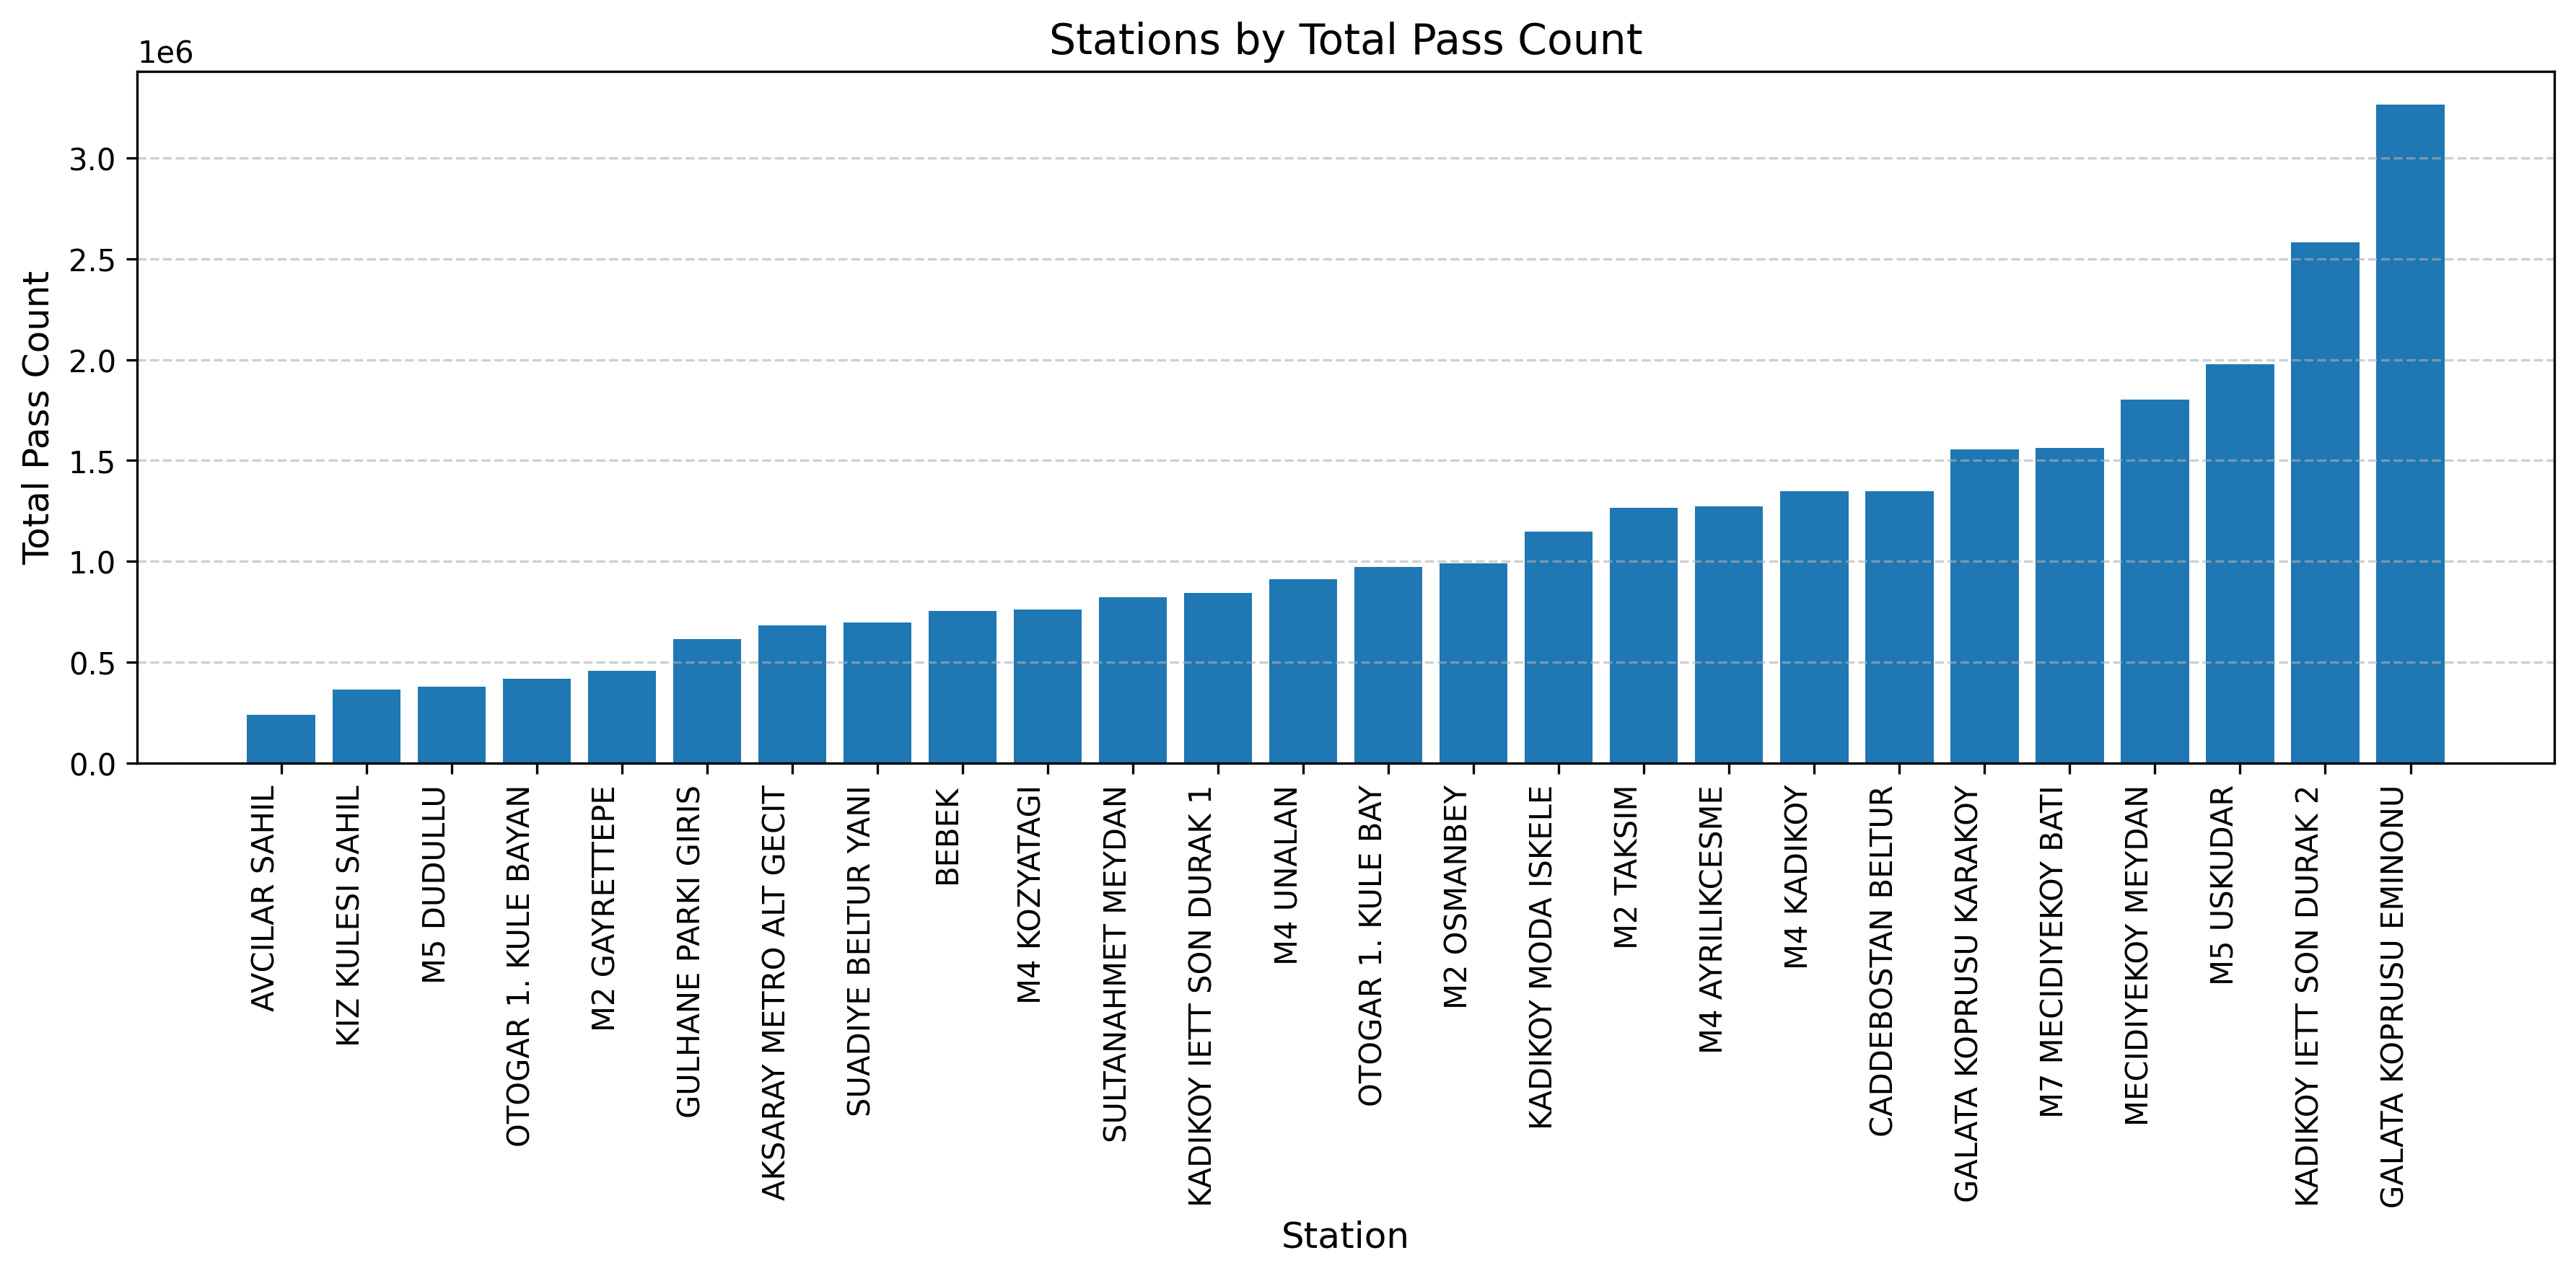

In [58]:
# Let's visualize the total pass count for each station.
# For each station, total pass counts across all months and years (the sum)
station_totals = (data.groupby("İstasyon")["Geçiş_Adedi"].sum().sort_values(ascending=True))

plt.figure(figsize=(12, 6), dpi=300)
plt.bar(station_totals.index,station_totals.values)

plt.title("Stations by Total Pass Count", fontsize=14)
plt.xlabel("Station", fontsize=12)
plt.ylabel("Total Pass Count", fontsize=12)

plt.xticks(rotation=90, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()

In [26]:
# This is the sum of all months and years for each station
# But if we plot the pass counts for each station for every year
# it must be more clear to understand the variations over time

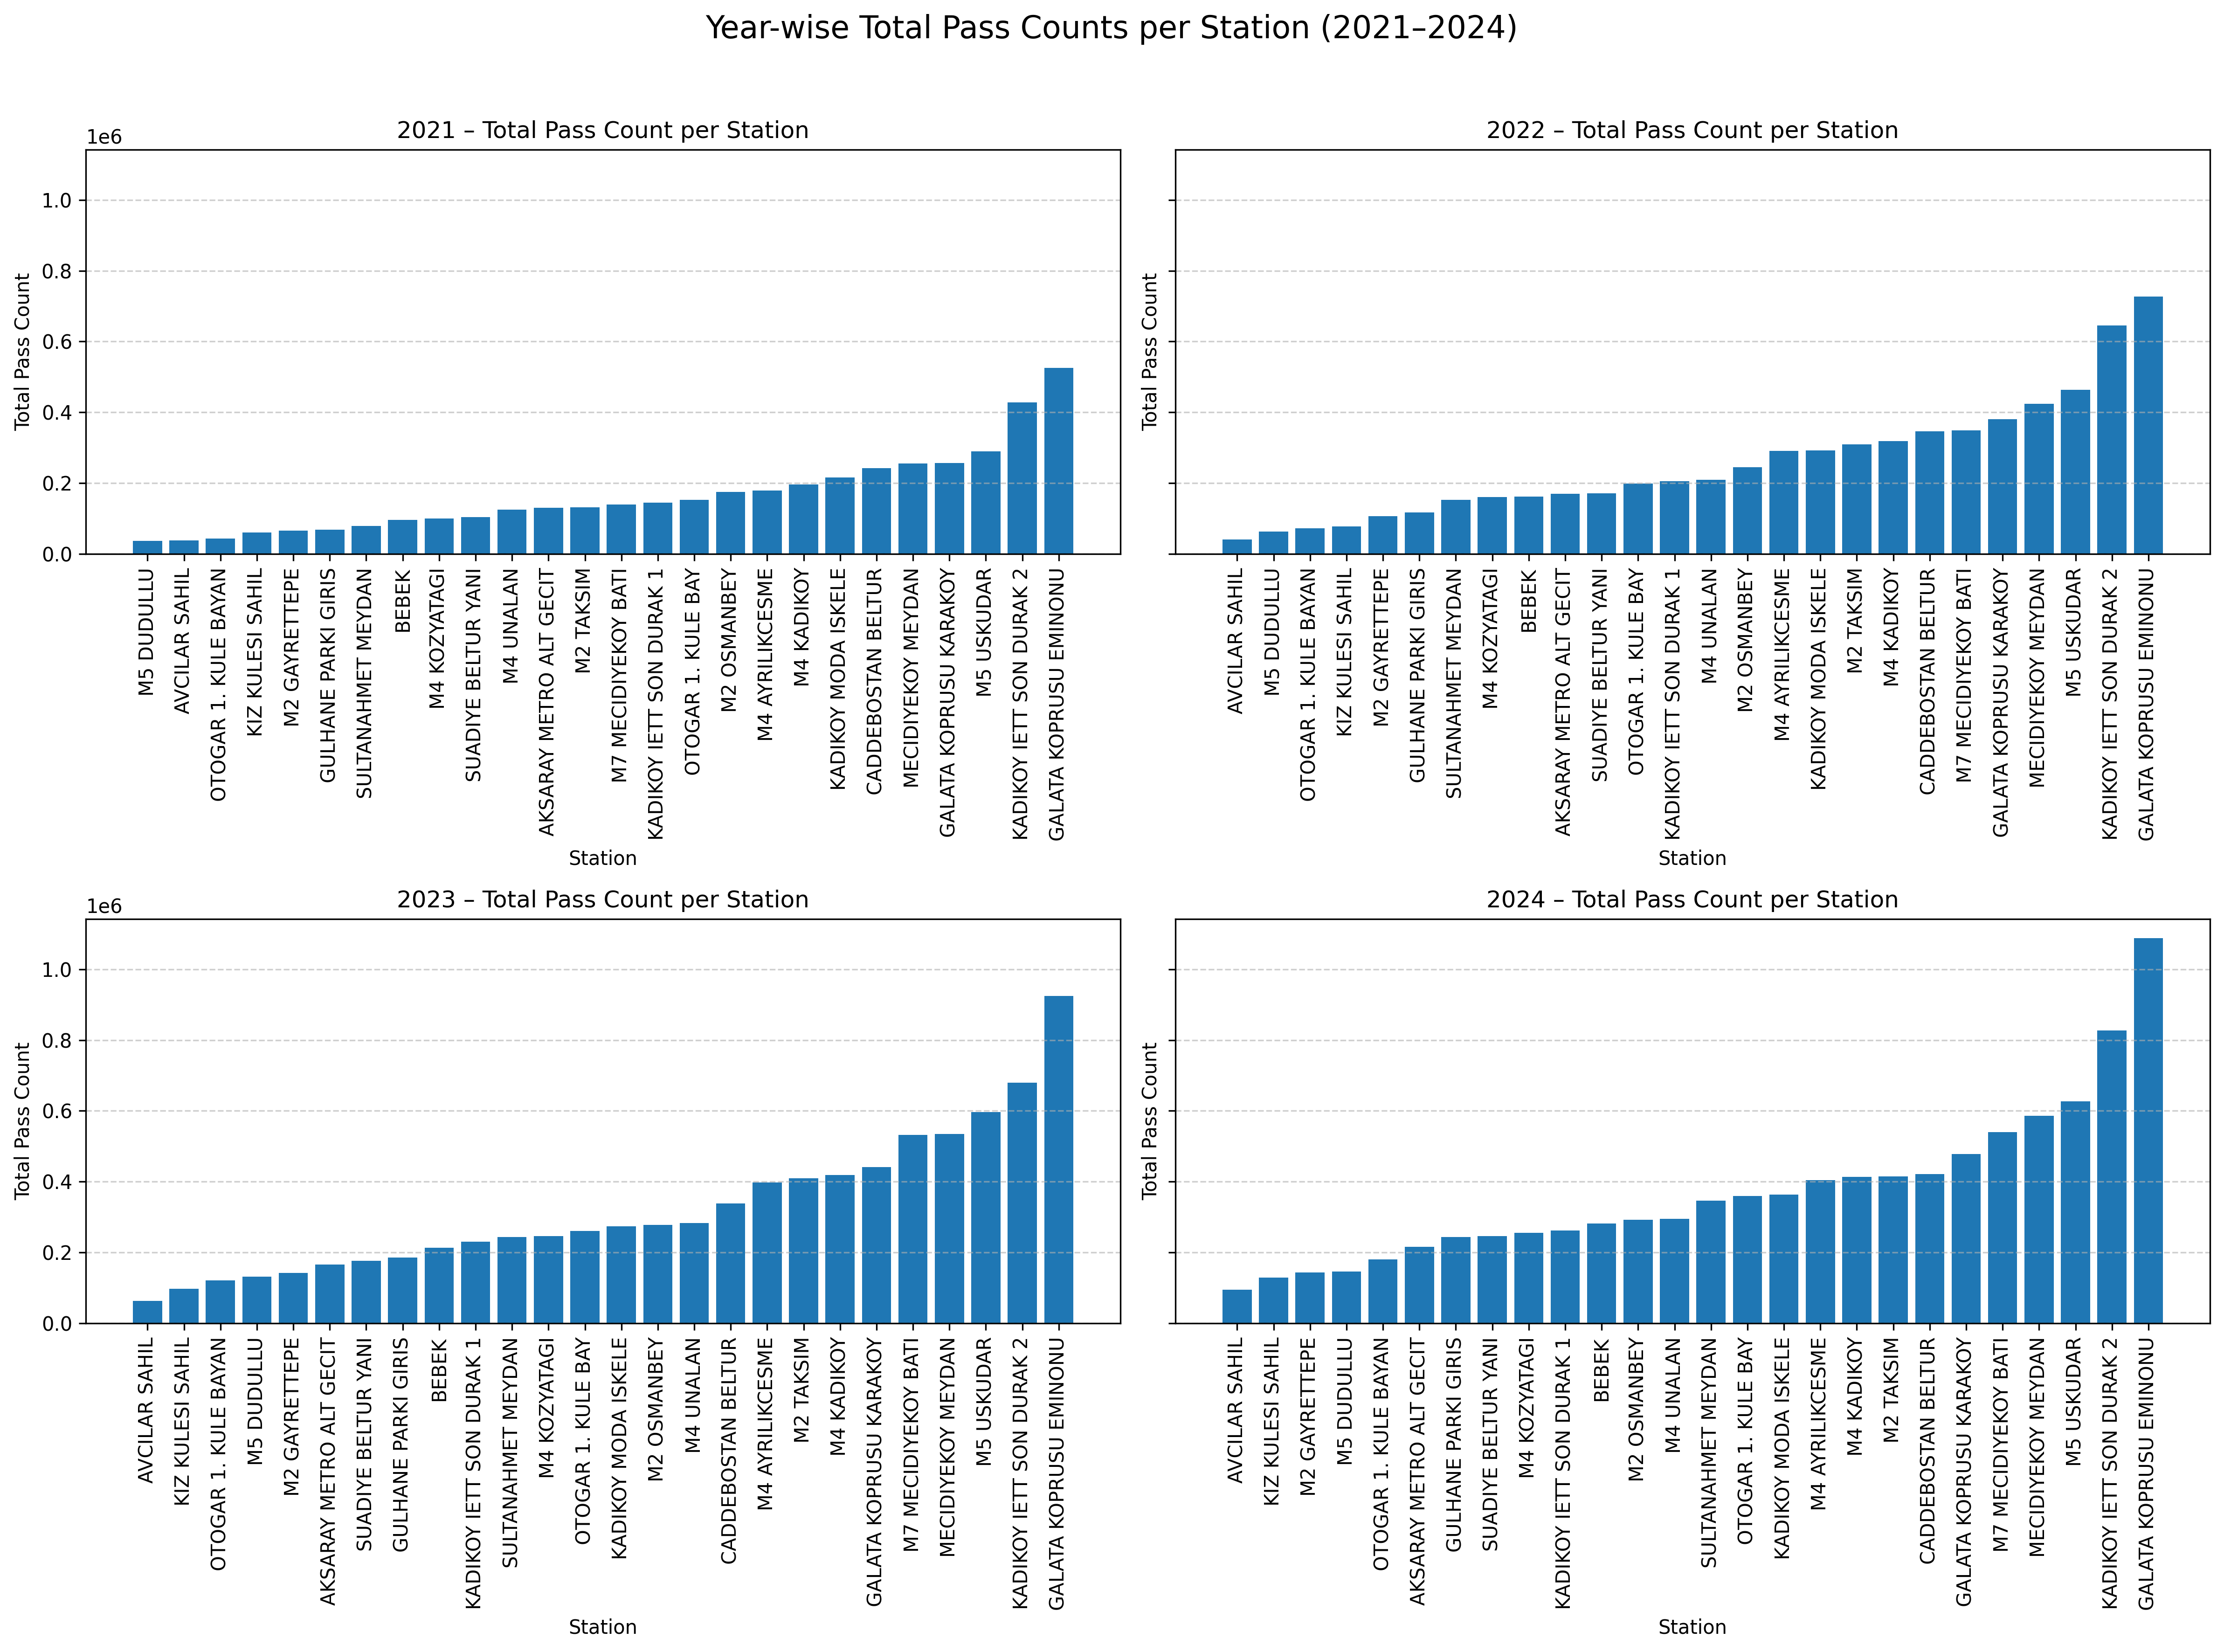

In [59]:
# Now, I will visualize the same graph as the above but it will seperated for years.
years = [2021, 2022, 2023, 2024]
data["Yıl"] = data["date"].dt.year

fig, axes = plt.subplots(2, 2, figsize=(16, 12), sharey=True, dpi = 300)
axes = axes.flatten()

for ax, year in zip(axes, years):
    yearly_totals = (data[data["Yıl"] == year].groupby("İstasyon")["Geçiş_Adedi"].sum().sort_values(ascending=True))
    
    ax.bar(yearly_totals.index, yearly_totals.values)
    ax.set_title(f"{year} – Total Pass Count per Station", fontsize=12)
    ax.set_xlabel("Station")
    ax.set_ylabel("Total Pass Count")
    
    ax.tick_params(axis="x", rotation=90)
    ax.grid(axis="y", linestyle="--", alpha=0.6)

plt.suptitle("Year-wise Total Pass Counts per Station (2021–2024)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

data = data.drop("Yıl", axis = 1)

In [28]:
# From this visualization, we can observe that some stations have highs pass count independent of the year. 
# This is a expected situation because while some stations are on the high traffic routes,
# others are on the low traffic routes. it does not depend on the year.

In [29]:
# Now let's visualize the monthly pass counts for to see if there are any seasonal patterns

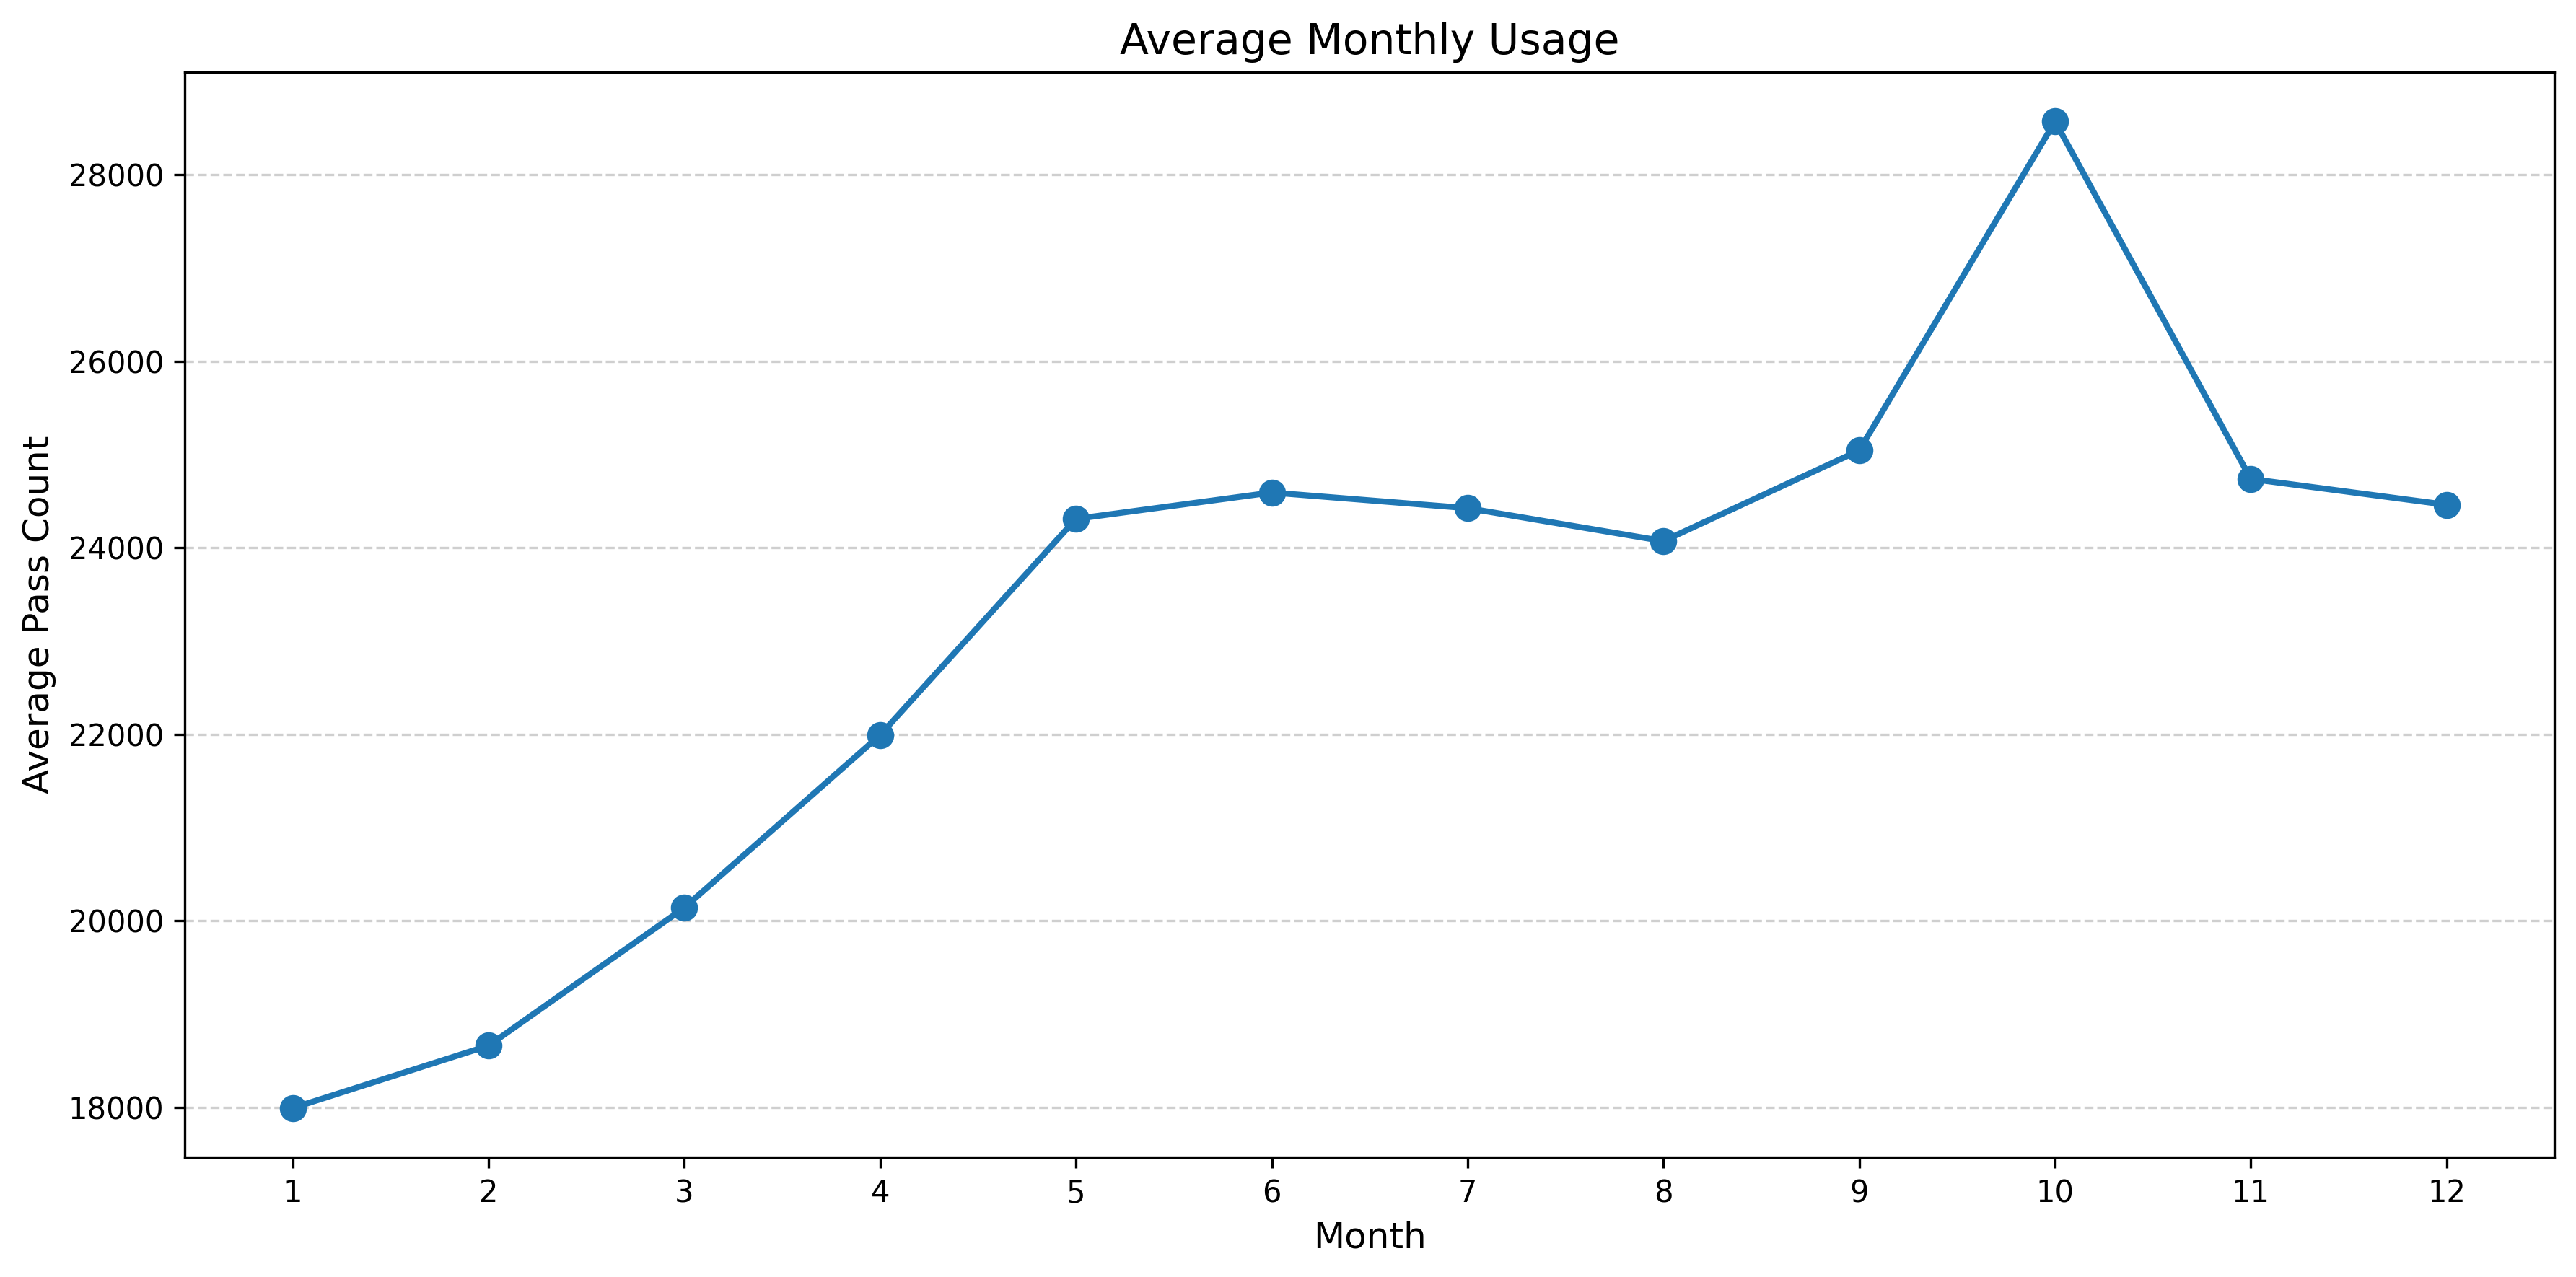

In [60]:
# I construct a new "month" column from the "date" column
# to facilitate monthly aggregation and analysis
data["month"] = data["date"].dt.month
monthly_avg = (data.groupby("month")["Geçiş_Adedi"].mean())

# Graph Settings
plt.figure(figsize=(12, 6), dpi=300)
plt.plot(monthly_avg.index, monthly_avg.values, marker="o", linewidth=2, markersize=8)
plt.title("Average Monthly Usage", fontsize=14)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Average Pass Count", fontsize=12)
plt.xticks(range(1, 13))
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

In [31]:
# The plotted results reveal a clear seasonal pattern in monthly pass counts.
# Usage tends to increase from January through May, then remains relatively stable
# during the summer months (June–August). A secondary rise appears from August to October,
# followed by a decline from October through December.

In [32]:
# Now let's make the outlier analysis
# To make this, I will use the IQR (Interquartile Range) method
# IQR is a measure of statistical dispersion and is calculated as the difference between
# the 75th percentile (Q3) and the 25th percentile (Q1) of the data.
# Data points that fall below Q1 - 1.5 * IQR or above Q3 + 1.5 * IQR
# are typically considered outliers.

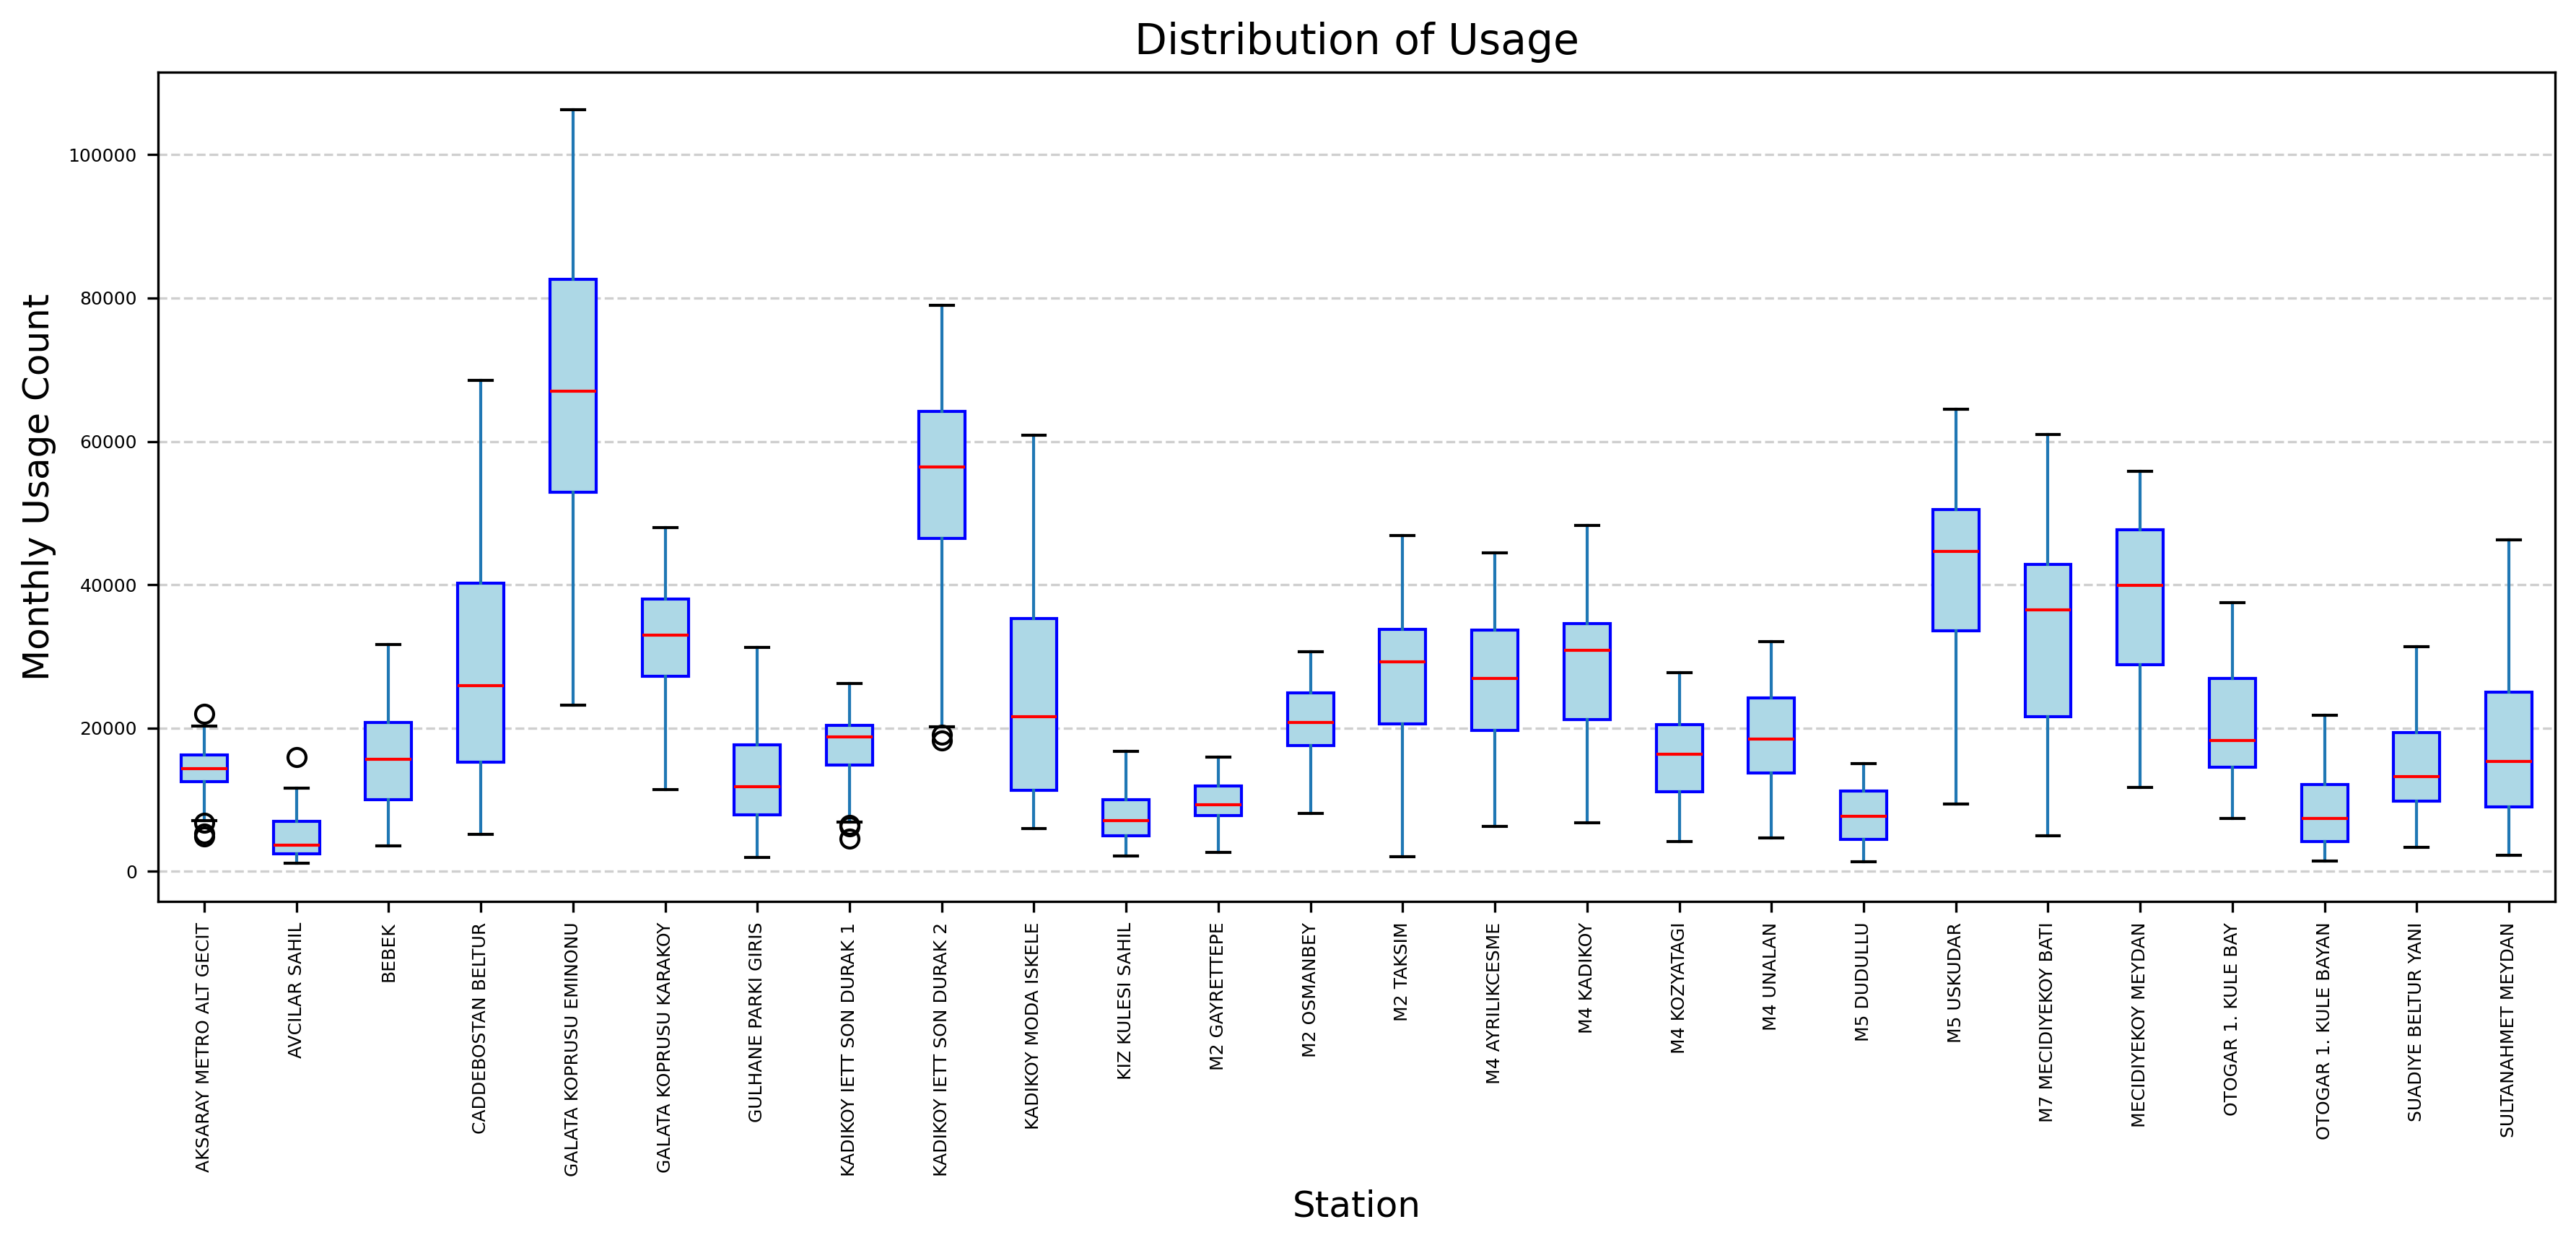

In [61]:
# Graph Settings
plt.figure(figsize=(12, 6),dpi = 300)
data.boxplot(column="Geçiş_Adedi",by="İstasyon",ax=plt.gca(),grid=False,rot=90,fontsize=6,patch_artist=True,boxprops=dict(facecolor="lightblue", color="blue"), medianprops=dict(color="red"))
plt.title("Distribution of Usage", fontsize=14)
plt.suptitle("")
plt.xlabel("Station", fontsize=12)
plt.ylabel("Monthly Usage Count", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

In [34]:
# The boxplot indicates that there are no severe or problematic outliers in the monthly
# pass counts across stations. While a few stations show isolated outlier points, these
# values are not extreme and do not warrant additional preprocessing at this stage.

# With this, the EDA phase is complete. We performed:
# - Station-level usage analysis
# - Monthly usage analysis
# - Seasonal pattern inspection
# - Outlier assessment

# We can now proceed to the Feature Engineering phase.

## 4. Preprocessing and Feature Engineering

To ensure a realistic forecasting setup, the dataset is split
**chronologically** rather than randomly.

- Training set: 2022–2023
- Test set: 2024

This simulates real-world deployment, where future data is unseen
at training time.

I will use 2021 to create lag features for the year 2022, and I do not use 2021 in the modeling because we dont have the year 2020 to create lag features for the year 2021

In [35]:
# I Prepare a working copy for feature engineering.
data_all = data
data_all = (data_all.sort_values(["İstasyon", "date"]).reset_index(drop=True))

In [36]:
# Create lag features (I create lag 1, 2, 3 and 12)
# that means the value of previous month, 2 months ago, 3 months ago and 12 months ago
data_all["lag_1"] = data_all.groupby("İstasyon")["Geçiş_Adedi"].shift(1)
data_all["lag_2"] = data_all.groupby("İstasyon")["Geçiş_Adedi"].shift(2)
data_all["lag_3"] = data_all.groupby("İstasyon")["Geçiş_Adedi"].shift(3)
data_all["lag_12"] = data_all.groupby("İstasyon")["Geçiş_Adedi"].shift(12)

In [37]:
# Create rolling mean features (this means the average of the previous 3 months)
tmp_roll = (data_all.groupby("İstasyon")["Geçiş_Adedi"].rolling(window=3).mean().reset_index(level=0, drop=True))

data_all["rolling_3"] = tmp_roll
data_all["rolling_3"] = data_all.groupby("İstasyon")["rolling_3"].shift(1)

In [38]:
# Let's create cyclical features for month
# It is necessary for month feature because month is cyclical
# and if we dont do this model may think that month 12 and month 1 are far away
data_all["month_sin"] = np.sin(2*np.pi*data_all["month"]/12)
data_all["month_cos"] = np.cos(2*np.pi*data_all["month"]/12)

In [39]:
# Let's create momentum and percentage change features
eps = 1.0 # small constant to avoid division by zero
data_all["mom_1"] = data_all["lag_1"] - data_all["lag_2"]
data_all["mom_3"] = data_all["lag_1"] - data_all["lag_3"]
data_all["pct_3"] = (data_all["lag_1"] - data_all["lag_3"]) / (data_all["lag_3"].abs() + eps)
data_all["rolling_3_std"] = data_all[["lag_1", "lag_2", "lag_3"]].std(axis=1)
data = data_all.copy().reset_index(drop=True)

In [40]:
# Lets look at the final dataset before going to modeling phase
data.head()

İstasyon       date  Geçiş_Adedi  month   lag_1   lag_2  \
0  AKSARAY METRO ALT GECIT 2021-01-01         5322      1     NaN     NaN   
1  AKSARAY METRO ALT GECIT 2021-02-01         4840      2  5322.0     NaN   
2  AKSARAY METRO ALT GECIT 2021-03-01         9217      3  4840.0  5322.0   
3  AKSARAY METRO ALT GECIT 2021-04-01         7057      4  9217.0  4840.0   
4  AKSARAY METRO ALT GECIT 2021-05-01         6803      5  7057.0  9217.0   

    lag_3  lag_12    rolling_3  month_sin     month_cos   mom_1   mom_3  \
0     NaN     NaN          NaN   0.500000  8.660254e-01     NaN     NaN   
1     NaN     NaN          NaN   0.866025  5.000000e-01     NaN     NaN   
2     NaN     NaN          NaN   1.000000  6.123234e-17  -482.0     NaN   
3  5322.0     NaN  6459.666667   0.866025 -5.000000e-01  4377.0  3895.0   
4  4840.0     NaN  7038.000000   0.500000 -8.660254e-01 -2160.0  2217.0   

      pct_3  rolling_3_std  
0       NaN            NaN  
1       NaN            NaN  
2       NaN     340.825469  
3  0.731730    2400.051319  
4  0.457963    2188.561857

In [41]:
# It looks nice, we have lag features, rolling mean features, 
# cyclical month features and momentum/percentage change features
# created and our rows are ordered well.

# Some values on the lag and rolling mean columns are NaN
# This is expected because we will not use 2021 for modeling, we start from 2022

# I think these features are enogugh for now. Let's move to data spliting and modeling.

In [42]:
# Let's split the data into train and test sets
# As I say before, I will use data 2022-2023 for training
# and data 2024 for testing
train_df = data[(data["date"] > "2021-12-01") & (data["date"] < "2024-01-01")].copy().reset_index(drop = True)
test_df = data[data["date"] >= "2024-01-01"].copy().reset_index(drop = True)

In [43]:
# Quick look at training rows to make sure split looks okey
train_df.head()

İstasyon       date  Geçiş_Adedi  month    lag_1    lag_2  \
0  AKSARAY METRO ALT GECIT 2022-01-01        12778      1  14339.0  15523.0   
1  AKSARAY METRO ALT GECIT 2022-02-01        13109      2  12778.0  14339.0   
2  AKSARAY METRO ALT GECIT 2022-03-01        14333      3  13109.0  12778.0   
3  AKSARAY METRO ALT GECIT 2022-04-01        10814      4  14333.0  13109.0   
4  AKSARAY METRO ALT GECIT 2022-05-01        16236      5  10814.0  14333.0   

     lag_3  lag_12     rolling_3  month_sin     month_cos   mom_1   mom_3  \
0  16454.0  5322.0  15438.666667   0.500000  8.660254e-01 -1184.0 -2115.0   
1  15523.0  4840.0  14213.333333   0.866025  5.000000e-01 -1561.0 -2745.0   
2  14339.0  9217.0  13408.666667   1.000000  6.123234e-17   331.0 -1230.0   
3  12778.0  7057.0  13406.666667   0.866025 -5.000000e-01  1224.0  1555.0   
4  13109.0  6803.0  12752.000000   0.500000 -8.660254e-01 -3519.0 -2295.0   

      pct_3  rolling_3_std  
0 -0.128532    1060.019025  
1 -0.176823    1376.808023  
2 -0.085774     822.514640  
3  0.121684     819.121684  
4 -0.175057    1786.456549

In [44]:
# Quick look at test rows to make sure split looks okey
test_df.head()

İstasyon       date  Geçiş_Adedi  month    lag_1    lag_2  \
0  AKSARAY METRO ALT GECIT 2024-01-01        17110      1  15523.0  15191.0   
1  AKSARAY METRO ALT GECIT 2024-02-01        18531      2  17110.0  15523.0   
2  AKSARAY METRO ALT GECIT 2024-03-01        15278      3  18531.0  17110.0   
3  AKSARAY METRO ALT GECIT 2024-04-01        18644      4  15278.0  18531.0   
4  AKSARAY METRO ALT GECIT 2024-05-01        20251      5  18644.0  15278.0   

     lag_3   lag_12     rolling_3  month_sin     month_cos   mom_1   mom_3  \
0  16293.0  13262.0  15669.000000   0.500000  8.660254e-01   332.0  -770.0   
1  15191.0  11719.0  15941.333333   0.866025  5.000000e-01  1587.0  1919.0   
2  15523.0  13484.0  17054.666667   1.000000  6.123234e-17  1421.0  3008.0   
3  17110.0  12404.0  16973.000000   0.866025 -5.000000e-01 -3253.0 -1832.0   
4  18531.0  13954.0  17484.333333   0.500000 -8.660254e-01  3366.0   113.0   

      pct_3  rolling_3_std  
0 -0.047257     565.321148  
1  0.126316    1025.618025  
2  0.193764    1504.763215  
3 -0.107066    1630.821572  
4  0.006098    1911.575877

In [45]:
# Show training dataframe info: types and non-null counts
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 624 entries, 0 to 623
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   İstasyon       624 non-null    object        
 1   date           624 non-null    datetime64[ns]
 2   Geçiş_Adedi    624 non-null    int64         
 3   month          624 non-null    int32         
 4   lag_1          624 non-null    float64       
 5   lag_2          624 non-null    float64       
 6   lag_3          624 non-null    float64       
 7   lag_12         624 non-null    float64       
 8   rolling_3      624 non-null    float64       
 9   month_sin      624 non-null    float64       
 10  month_cos      624 non-null    float64       
 11  mom_1          624 non-null    float64       
 12  mom_3          624 non-null    float64       
 13  pct_3          624 non-null    float64       
 14  rolling_3_std  624 non-null    float64       
dtypes: datetime64[ns](1), f

In [46]:
# Show test dataframe info: types and non-null counts
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 312 entries, 0 to 311
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   İstasyon       312 non-null    object        
 1   date           312 non-null    datetime64[ns]
 2   Geçiş_Adedi    312 non-null    int64         
 3   month          312 non-null    int32         
 4   lag_1          312 non-null    float64       
 5   lag_2          312 non-null    float64       
 6   lag_3          312 non-null    float64       
 7   lag_12         312 non-null    float64       
 8   rolling_3      312 non-null    float64       
 9   month_sin      312 non-null    float64       
 10  month_cos      312 non-null    float64       
 11  mom_1          312 non-null    float64       
 12  mom_3          312 non-null    float64       
 13  pct_3          312 non-null    float64       
 14  rolling_3_std  312 non-null    float64       
dtypes: datetime64[ns](1), f

In [47]:
# Everything is true.
# Let's go to the modeling phase.

## 5. Baseline Models and Model Training

In this section, I will build three baseline models and train the machine learning model.

- Baseline 1: Seasonal Naive (Lag-12)
- Baseline 2: Rolling Mean (Window = 3)
- Baseline 3: Hybrid (Lag-12 + Rolling-3)

- Machine Learning Model: CatBoost Regressor

These baselines will provide a reference point to objectively evaluate the performance of the machine learning model.

In [48]:
#---------------------
# THE BASELINE MODELS
#---------------------
# I set the common evaluation set for all baselines to ensure fair comparison
common_test = test_df.dropna(subset=["lag_12", "rolling_3"]).copy()

y_true = common_test["Geçiş_Adedi"].values

def eval_metrics(y, yhat):
    mae = np.mean(np.abs(y - yhat))
    rmse = np.sqrt(np.mean((y - yhat) ** 2))
    return mae, rmse

# BASELINE 1: Seasonal Naive (Lag-12) 
# This baseline uses the value from the same month last year as the prediction
common_test["pred_lag12"] = common_test["lag_12"]
mae_b1, rmse_b1 = eval_metrics(y_true, common_test["pred_lag12"].values)

# BASELINE 2: Rolling Mean (Rolling-3)
# This baseline uses the rolling mean of the previous 3 months as the prediction
common_test["pred_roll3"] = common_test["rolling_3"]
mae_b2, rmse_b2 = eval_metrics(y_true, common_test["pred_roll3"].values)

# BASELINE 3: Hybrid (Lag-12 + Rolling-3)
# This baseline uses the average of the Lag-12 and Rolling-3 predictions
common_test["pred_hybrid"] = (0.5 * common_test["lag_12"] + 0.5 * common_test["rolling_3"])
mae_b3, rmse_b3 = eval_metrics(y_true, common_test["pred_hybrid"].values)

# Print results
print("BASELINE RESULTS")
print(f"Baseline-1 (Lag-12)        MAE: {mae_b1:.2f} | RMSE: {rmse_b1:.2f}")
print(f"Baseline-2 (Rolling-3)     MAE: {mae_b2:.2f} | RMSE: {rmse_b2:.2f}")
print(f"Baseline-3 (Hybrid)        MAE: {mae_b3:.2f} | RMSE: {rmse_b3:.2f}")

BASELINE RESULTS
Baseline-1 (Lag-12)        MAE: 5901.62 | RMSE: 8020.03
Baseline-2 (Rolling-3)     MAE: 5477.45 | RMSE: 7446.98
Baseline-3 (Hybrid)        MAE: 4389.13 | RMSE: 6294.16


In [49]:
# We can see that our baseline models give reasonable performance.
# The best performance is achieved by the hybrid model,
# which combines the Lag-12 and Rolling-3 approaches.
# Let's train our machine learning model and compare the results with these baselines.

In [50]:
#-----------------------------
# THE MACHINE LEARNING MODEL
#-----------------------------
train_df = train_df.reset_index(drop=True) 
features = ["İstasyon","month","lag_1", "lag_2", "lag_3", "lag_12","rolling_3","rolling_3_std","month_sin", "month_cos","mom_1", "mom_3", "pct_3"]
target = "Geçiş_Adedi"
cat_features = ["İstasyon"]
date_col = 'date'

unique_dates = np.sort(train_df[date_col].unique())
tscv = TimeSeriesSplit(n_splits=3)

custom_cv = []

for train_date_index, val_date_index in tscv.split(unique_dates):
    train_dates = unique_dates[train_date_index]
    val_dates = unique_dates[val_date_index]
    train_indices = train_df[train_df[date_col].isin(train_dates)].index.values.astype(int)
    val_indices = train_df[train_df[date_col].isin(val_dates)].index.values.astype(int)
    custom_cv.append((train_indices, val_indices))

print(f"Fold 1 Train Size: {len(custom_cv[0][0])}, Val Size: {len(custom_cv[0][1])}")

X_train = train_df[features]
y_train = train_df[target]

train_pool = Pool(data=X_train, label=y_train, cat_features=cat_features)

X_test  = test_df[features]
y_test  = test_df[target]
test_pool = Pool(data=X_test, label=y_test, cat_features=cat_features)

param_grid = {
    "depth": [4, 6],
    "learning_rate": [0.03, 0.05],
    "l2_leaf_reg": [3, 6],
    "min_data_in_leaf": [20, 30, 50],
    "subsample": [0.8],
    "colsample_bylevel": [0.8]
}

base_model = CatBoostRegressor(
    loss_function="RMSE",
    eval_metric="RMSE",
    n_estimators=1500,
    boosting_type="Ordered",
    random_seed=SEED,
    thread_count=1,
    verbose=False
)

base_model.grid_search(
    param_grid=param_grid,
    X=train_pool,
    cv=custom_cv,  
    shuffle=False,
    partition_random_seed=SEED,
    refit=True
)

final_model = base_model 
y_pred = final_model.predict(test_pool)

mae  = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("CATBOOST MODEL RESULTS (TRAINED ON RMSE")
print(f"MAE : {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

Fold 1 Train Size: 156, Val Size: 156

bestTest = 3953.672696
bestIteration = 1440

0:	loss: 3953.6726958	best: 3953.6726958 (0)	total: 2.44s	remaining: 56.1s

bestTest = 4106.508711
bestIteration = 838

1:	loss: 4106.5087113	best: 3953.6726958 (0)	total: 4.92s	remaining: 54.1s

bestTest = 4117.317888
bestIteration = 685

2:	loss: 4117.3178879	best: 3953.6726958 (0)	total: 7.56s	remaining: 52.9s

bestTest = 4138.622754
bestIteration = 784

3:	loss: 4138.6227543	best: 3953.6726958 (0)	total: 9.84s	remaining: 49.2s

bestTest = 4333.594978
bestIteration = 1495

4:	loss: 4333.5949783	best: 3953.6726958 (0)	total: 17.9s	remaining: 1m 7s

bestTest = 4239.253143
bestIteration = 191

5:	loss: 4239.2531432	best: 3953.6726958 (0)	total: 26.3s	remaining: 1m 18s

bestTest = 4316.434304
bestIteration = 442

6:	loss: 4316.4343038	best: 3953.6726958 (0)	total: 34.8s	remaining: 1m 24s

bestTest = 4277.916632
bestIteration = 1367

7:	loss: 4277.9166323	best: 3953.6726958 (0)	total: 43.4s	remaining: 1m 

## 6. Evaluation

In this section, I will evaluate the machine learning model using 4 different technics. 

- SHAP for Explainable AI
- Feature correlation heatmap for see correlation
- Station Wise Error Analysis (RMSE AND MAE)
- Actual vs Forecasted Plotting (For Top 4, Less 4 and All Stations)

/var/folders/3z/7sv1xp_96lgbrt8j1qdjwxdc0000gn/T/ipykernel_5376/1512352591.py:12: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values,X_shap,plot_type="dot",show=False)


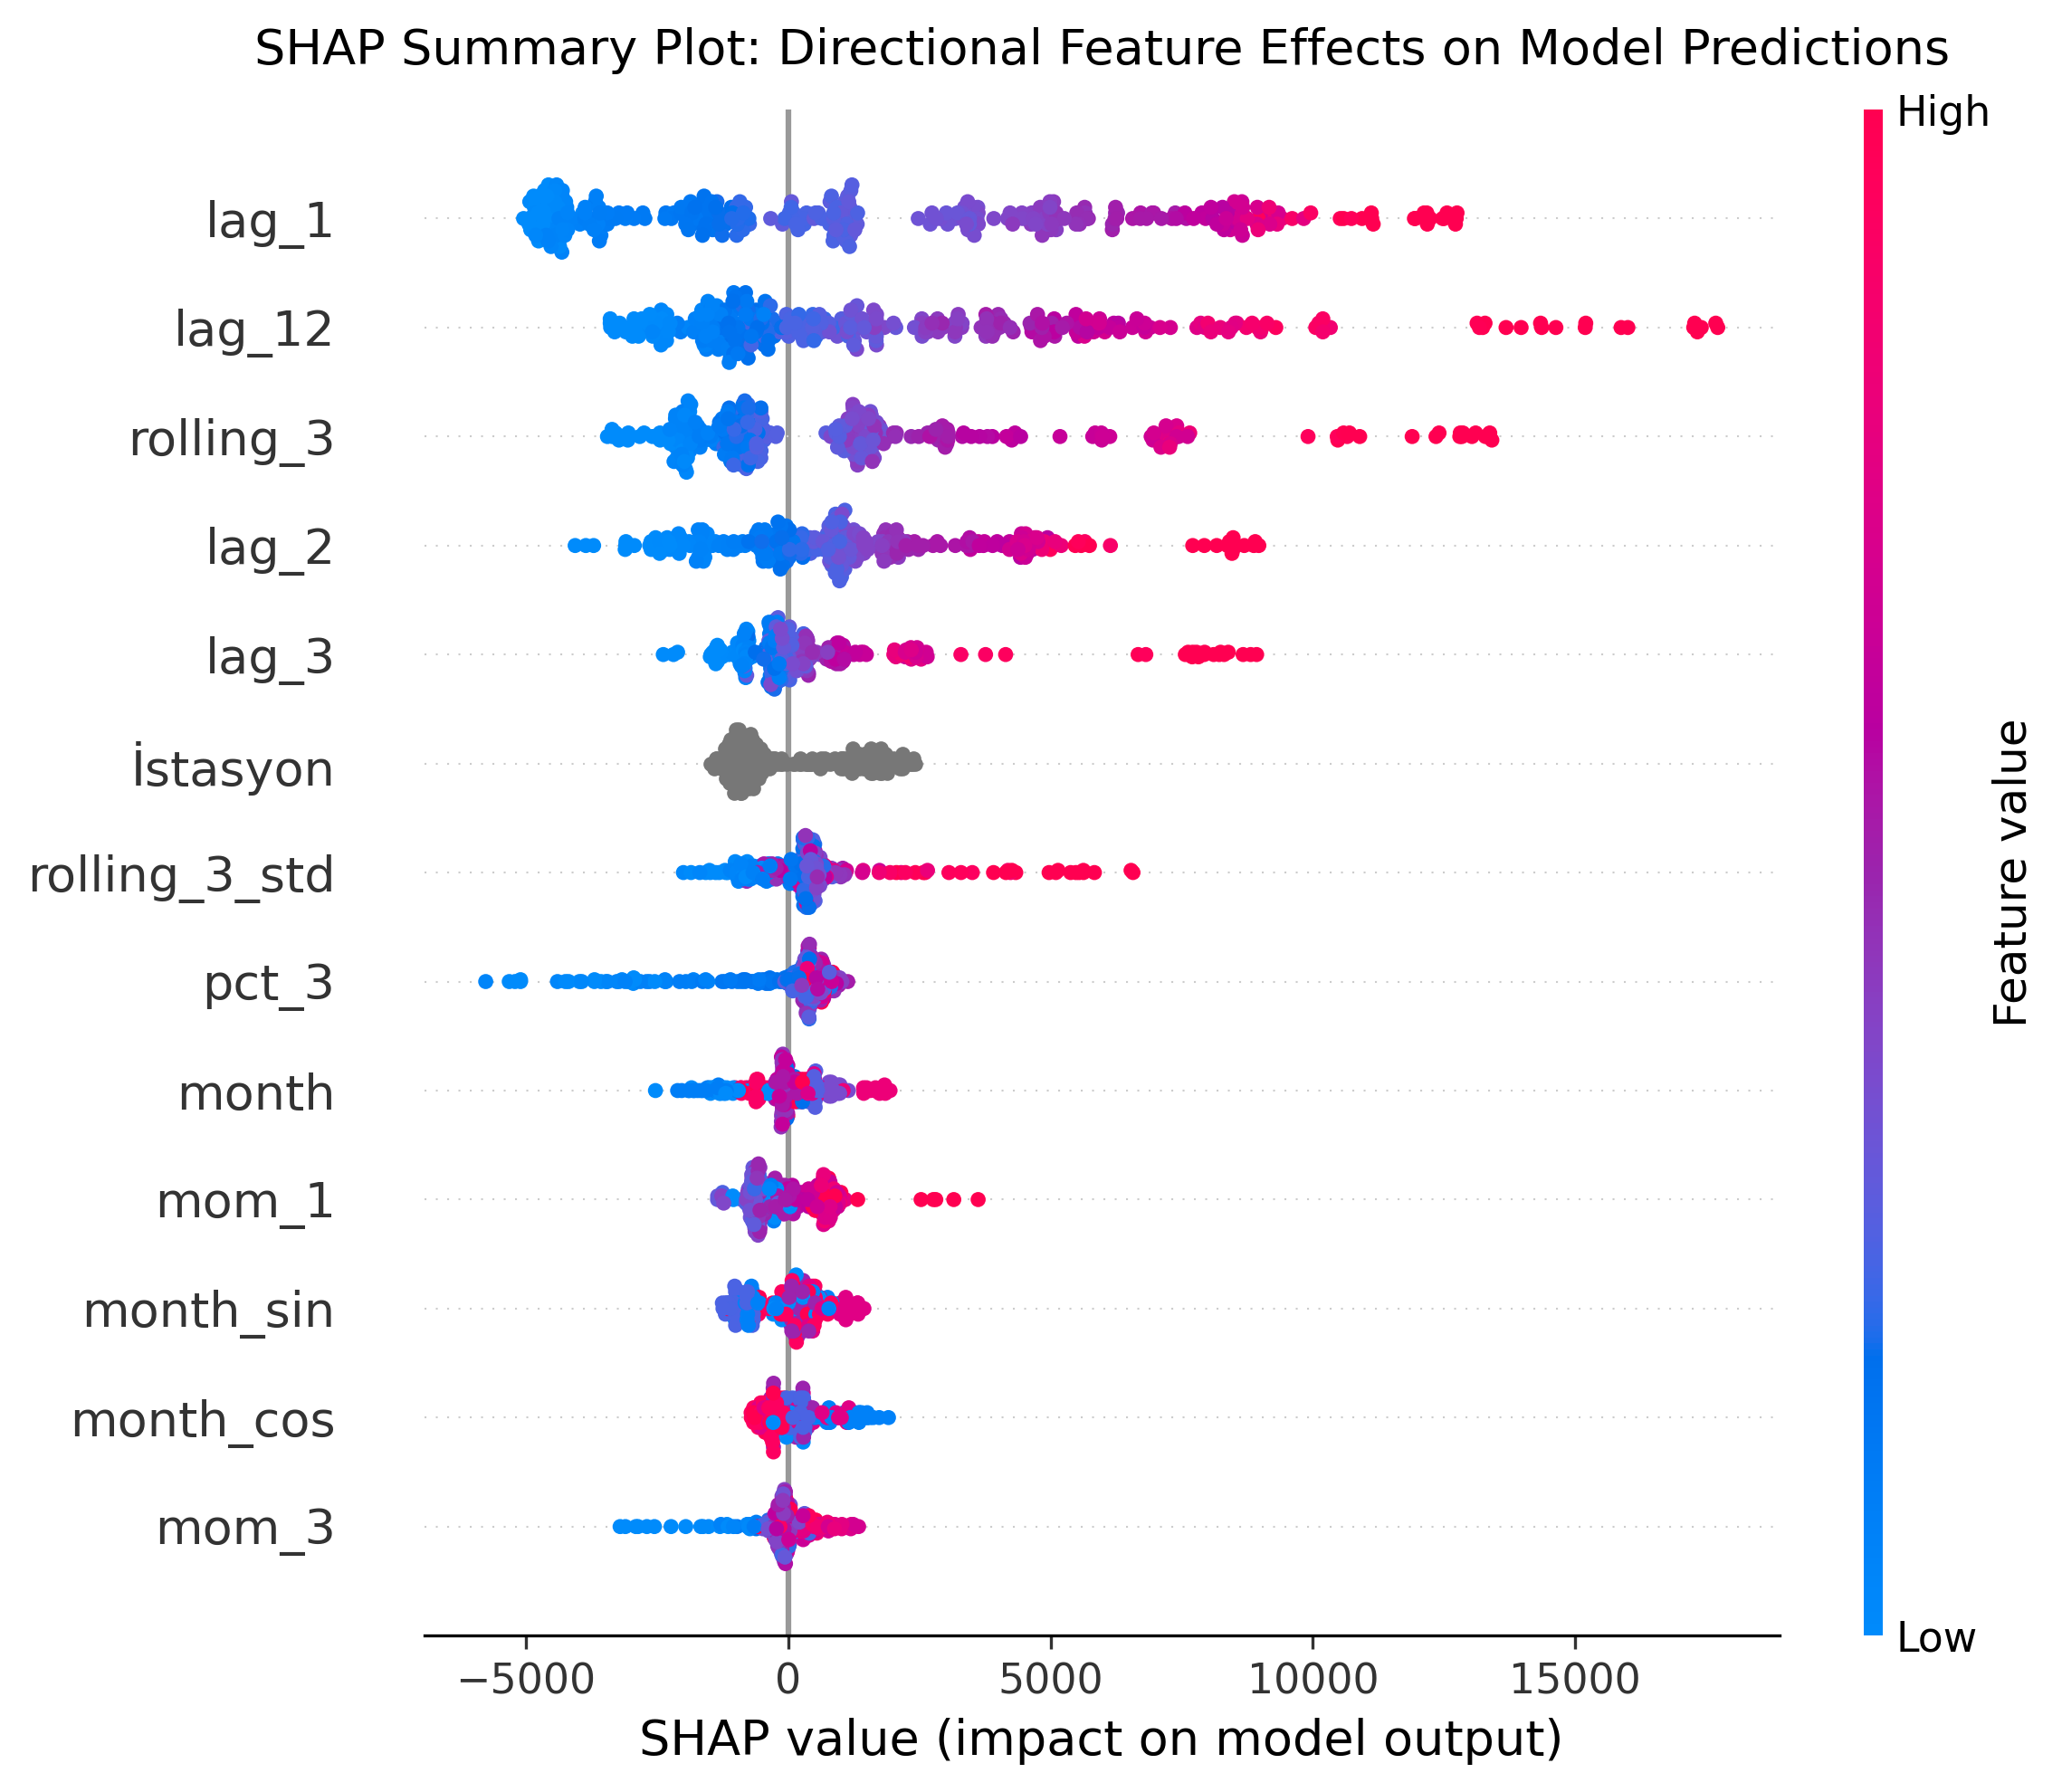

/var/folders/3z/7sv1xp_96lgbrt8j1qdjwxdc0000gn/T/ipykernel_5376/1512352591.py:17: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values,X_shap,plot_type="bar",show=False)


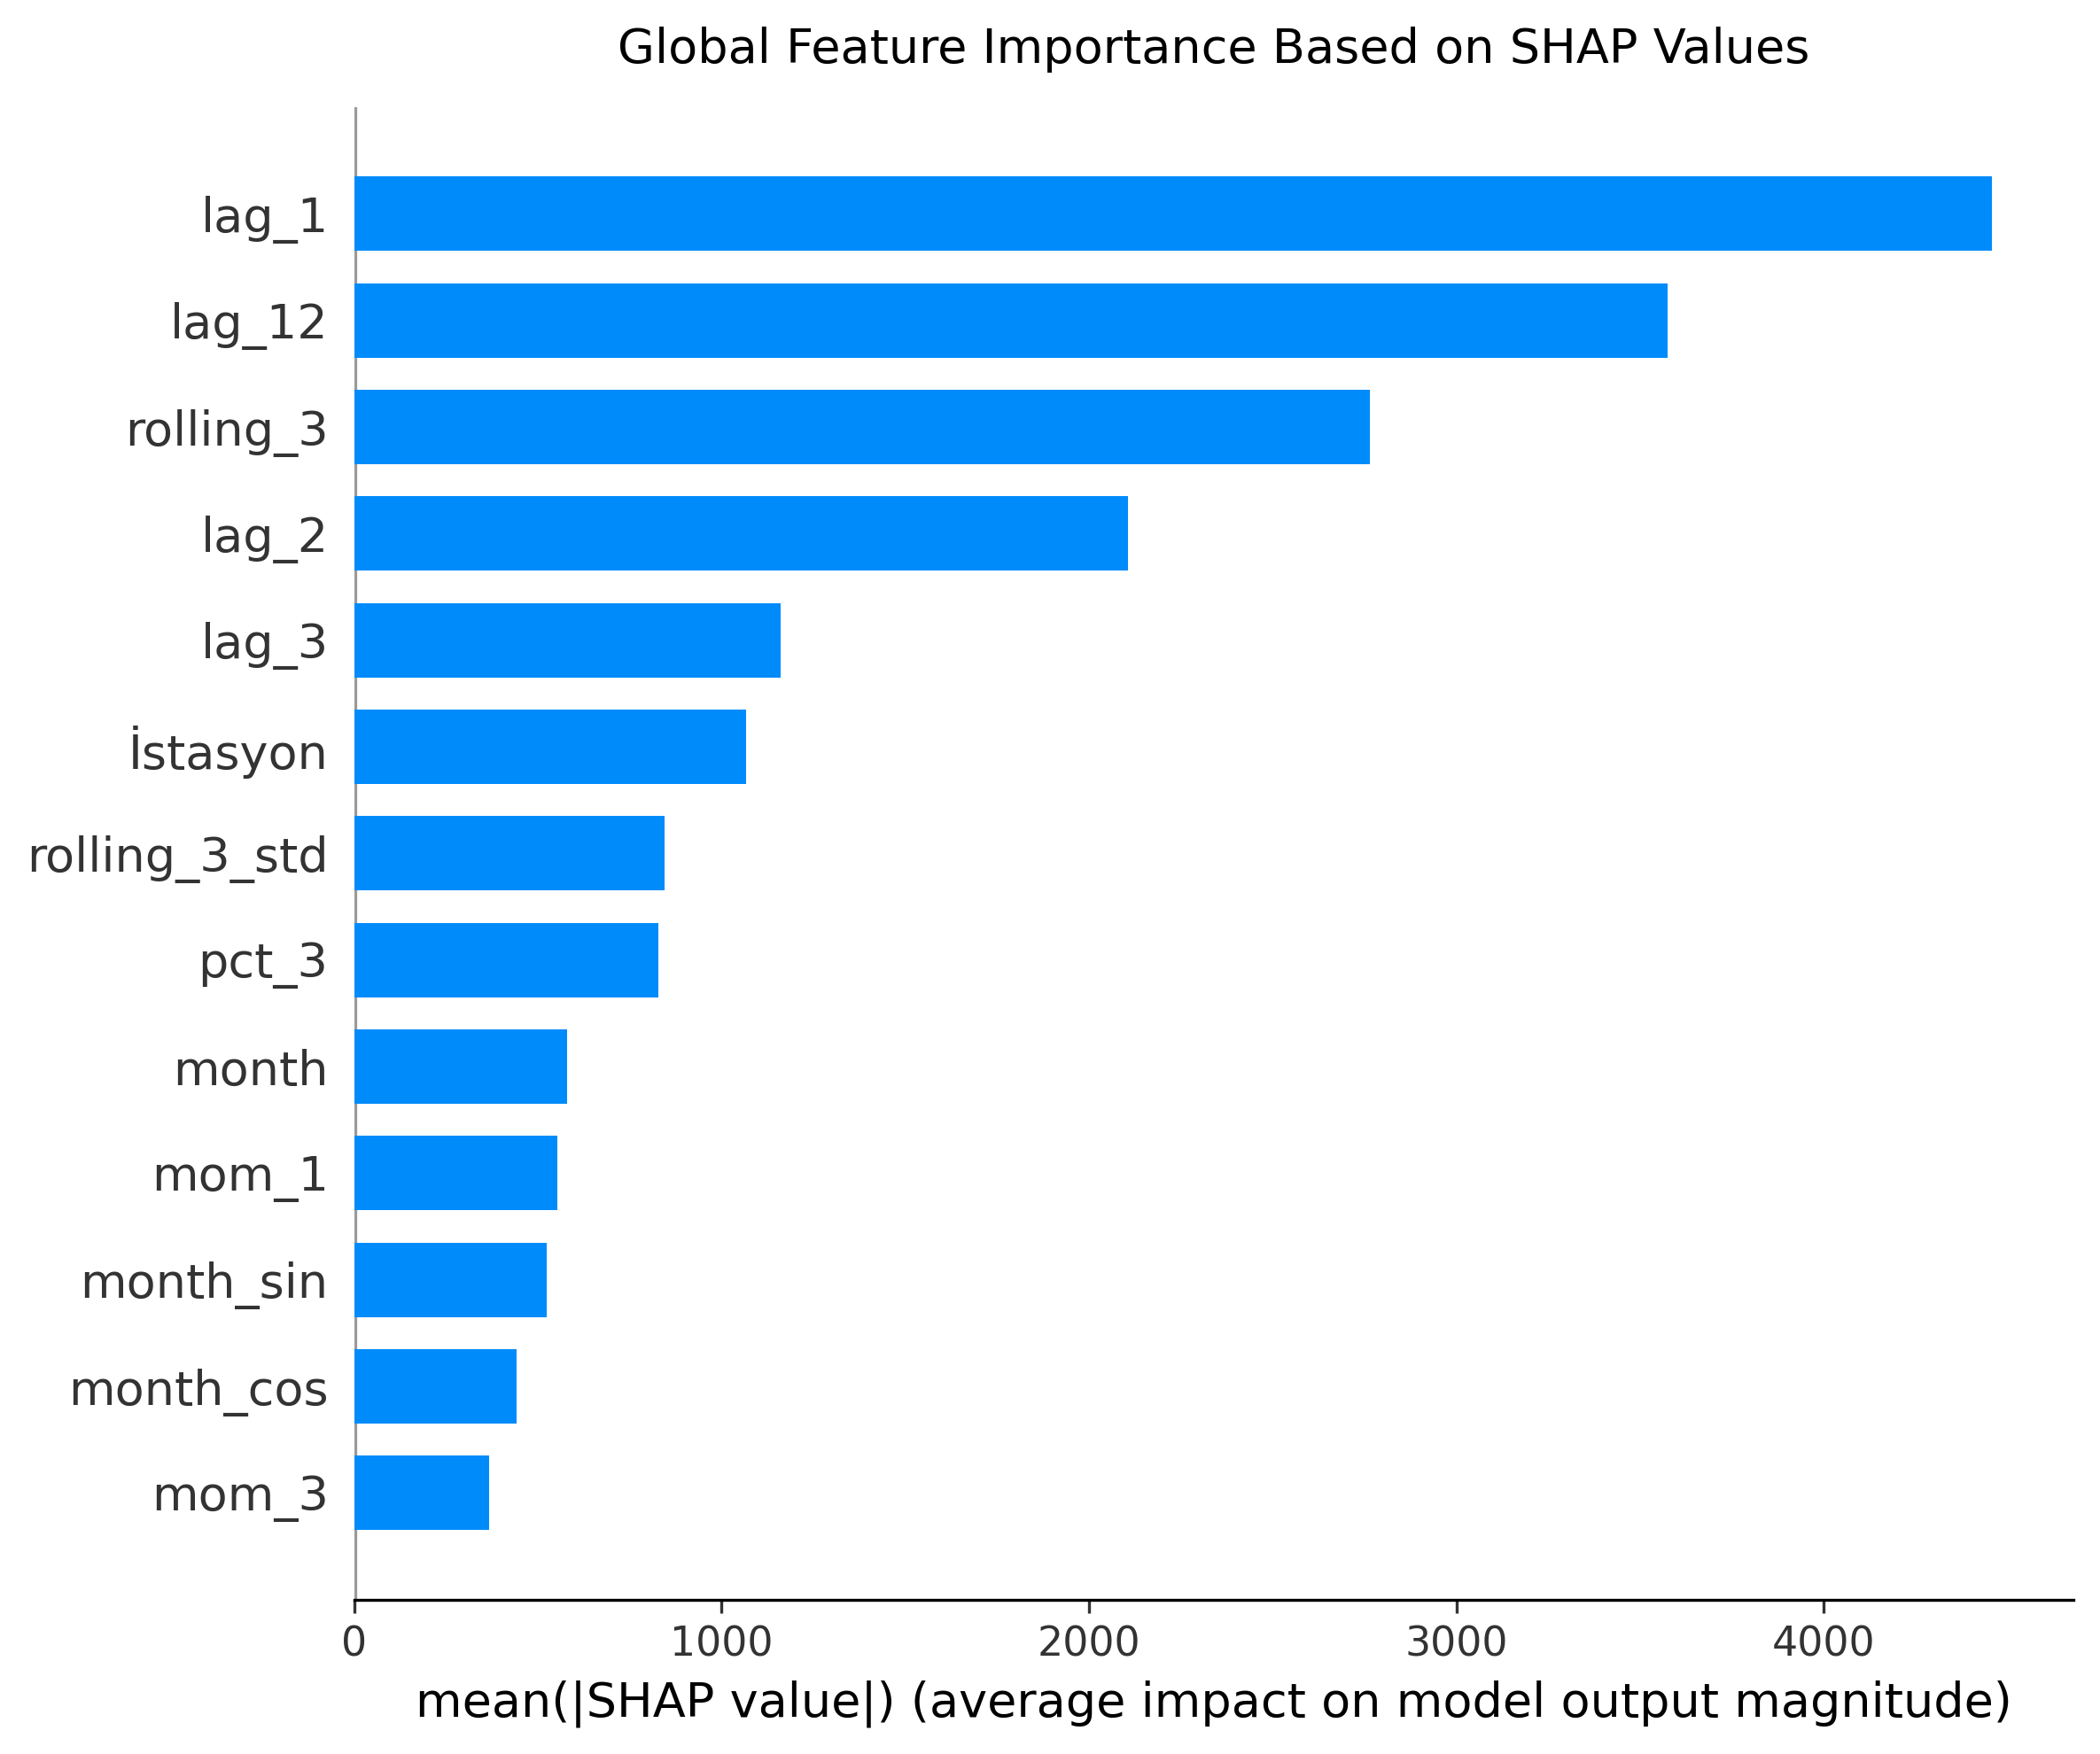

In [62]:
#----------------------
# SHAP Explainability
#----------------------
n_shap = min(1000, len(X_test))
X_shap = X_test.sample(n=n_shap, random_state=42)

shap_values = final_model.get_feature_importance(data=Pool(X_shap, cat_features=cat_features),type="ShapValues")
shap_values = shap_values[:, :-1]

# Graph Settings
plt.figure(figsize=(8, 6), dpi = 300)
shap.summary_plot(shap_values,X_shap,plot_type="dot",show=False)
plt.title("SHAP Summary Plot: Directional Feature Effects on Model Predictions",fontsize=13,pad=12)
plt.tight_layout()
plt.show()
plt.figure(figsize=(8, 6), dpi = 300)
shap.summary_plot(shap_values,X_shap,plot_type="bar",show=False)
plt.title("Global Feature Importance Based on SHAP Values",fontsize=13,pad=12)
plt.tight_layout()
plt.show()

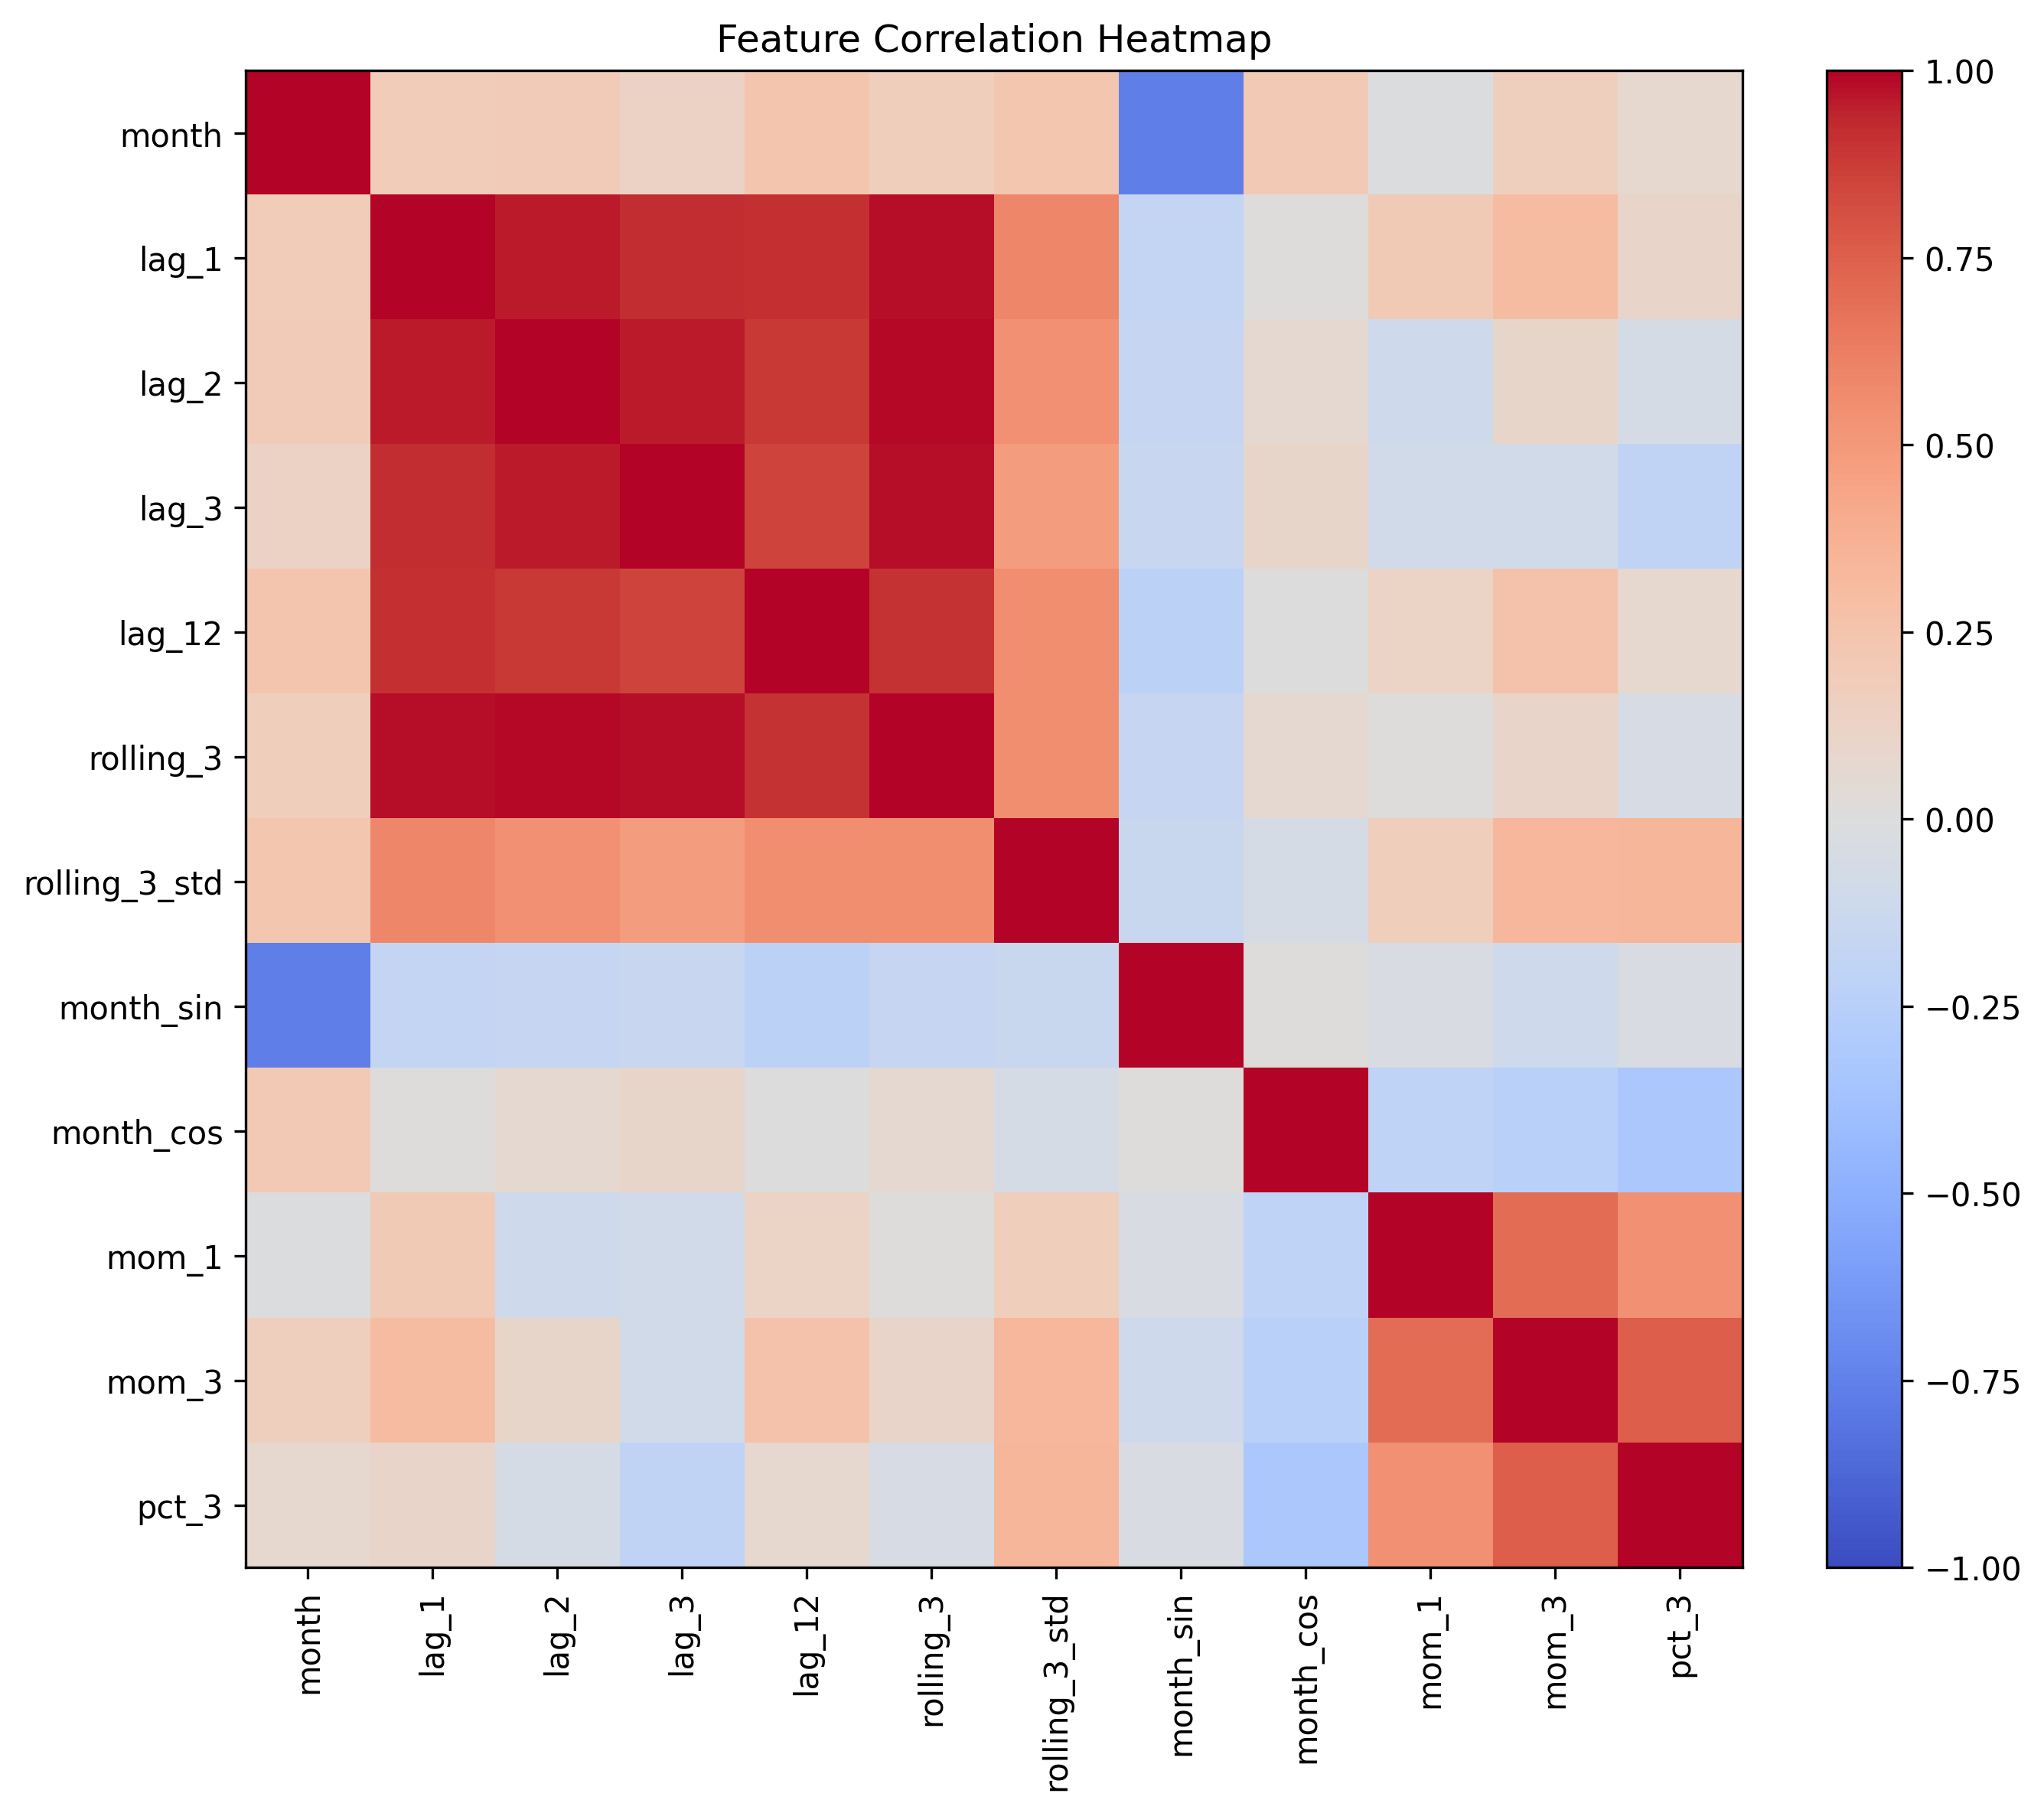

In [63]:
#-----------------------------
# FEATURE CORRELATION HEATMAP
#-----------------------------
# For the correlation matrix we must select numeric features only
numeric_features = ["month","lag_1", "lag_2", "lag_3", "lag_12","rolling_3", "rolling_3_std","month_sin", "month_cos","mom_1", "mom_3", "pct_3"]
# Compute correlation matrix on train data
corr = train_df[numeric_features].corr()

# Graph Settings
plt.figure(figsize=(10, 8),dpi=300)
im = plt.imshow(corr, cmap="coolwarm", vmin=-1, vmax=1)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.xticks(ticks=np.arange(len(numeric_features)),labels=numeric_features,rotation=90)
plt.yticks(ticks=np.arange(len(numeric_features)),labels=numeric_features)
plt.title("Feature Correlation Heatmap")
plt.tight_layout()
plt.show()

/var/folders/3z/7sv1xp_96lgbrt8j1qdjwxdc0000gn/T/ipykernel_5376/395112736.py:7: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  station_errors = (results_df.groupby("İstasyon").apply(lambda df: pd.Series({"MAE": mean_absolute_error(df[target], df["y_pred"]),"RMSE": np.sqrt(mean_squared_error(df[target], df["y_pred"]))})).reset_index().sort_values("RMSE", ascending=False))


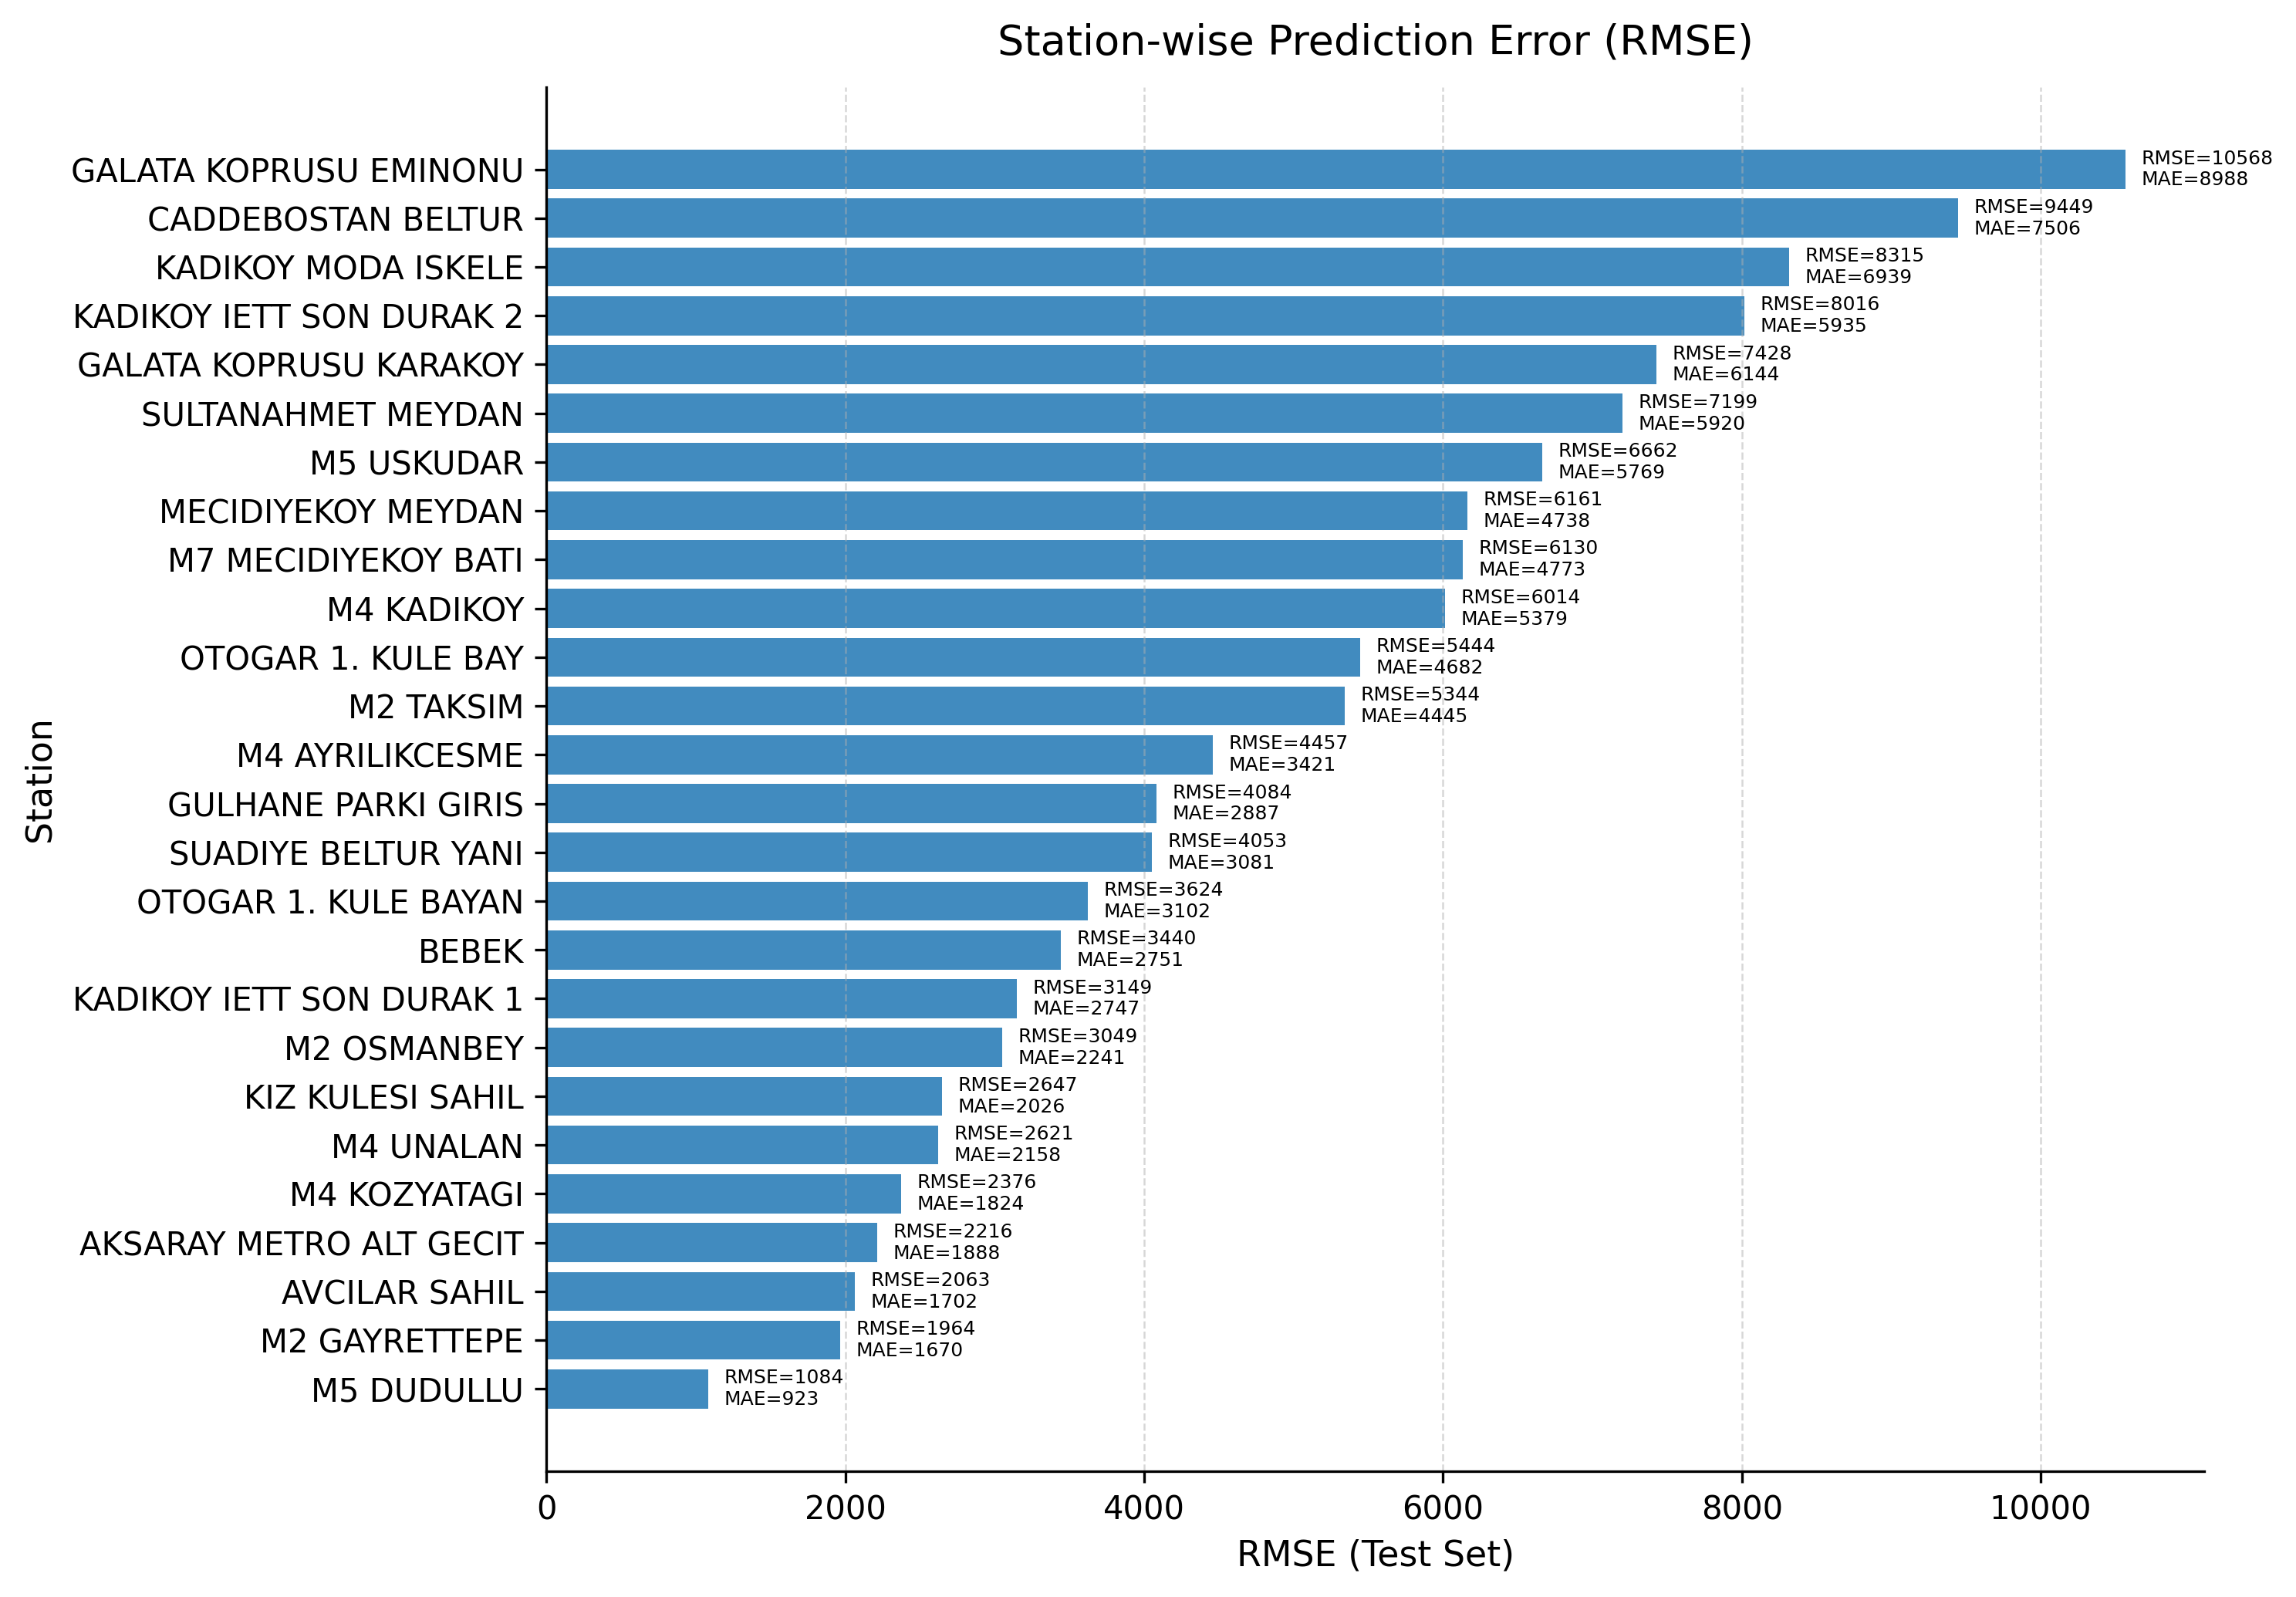

In [53]:
#-----------------------------
# STATION-WISE ERROR ANALYSIS
#-----------------------------
# Compute station-wise RMSE and MAE for test predictions and plot results
results_df = test_df[["İstasyon", target]].copy()
results_df["y_pred"] = y_pred
station_errors = (results_df.groupby("İstasyon").apply(lambda df: pd.Series({"MAE": mean_absolute_error(df[target], df["y_pred"]),"RMSE": np.sqrt(mean_squared_error(df[target], df["y_pred"]))})).reset_index().sort_values("RMSE", ascending=False))

# Graph Settings
fig, ax = plt.subplots(figsize=(10, 7), dpi=300)
bars = ax.barh(station_errors["İstasyon"],station_errors["RMSE"],alpha=0.85)
ax.invert_yaxis()
ax.set_xlabel("RMSE (Test Set)", fontsize=11)
ax.set_ylabel("Station", fontsize=11)
ax.set_title("Station-wise Prediction Error (RMSE)", fontsize=13, pad=10)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.grid(axis="x", linestyle="--", linewidth=0.6, alpha=0.5)
x_offset = 0.01 * station_errors["RMSE"].max()
for bar, mae, rmse in zip(bars, station_errors["MAE"], station_errors["RMSE"]):
    ax.text(rmse + x_offset,bar.get_y() + bar.get_height() / 2,f"RMSE={rmse:.0f}\nMAE={mae:.0f}",va="center",fontsize=6)
plt.tight_layout()
plt.show()

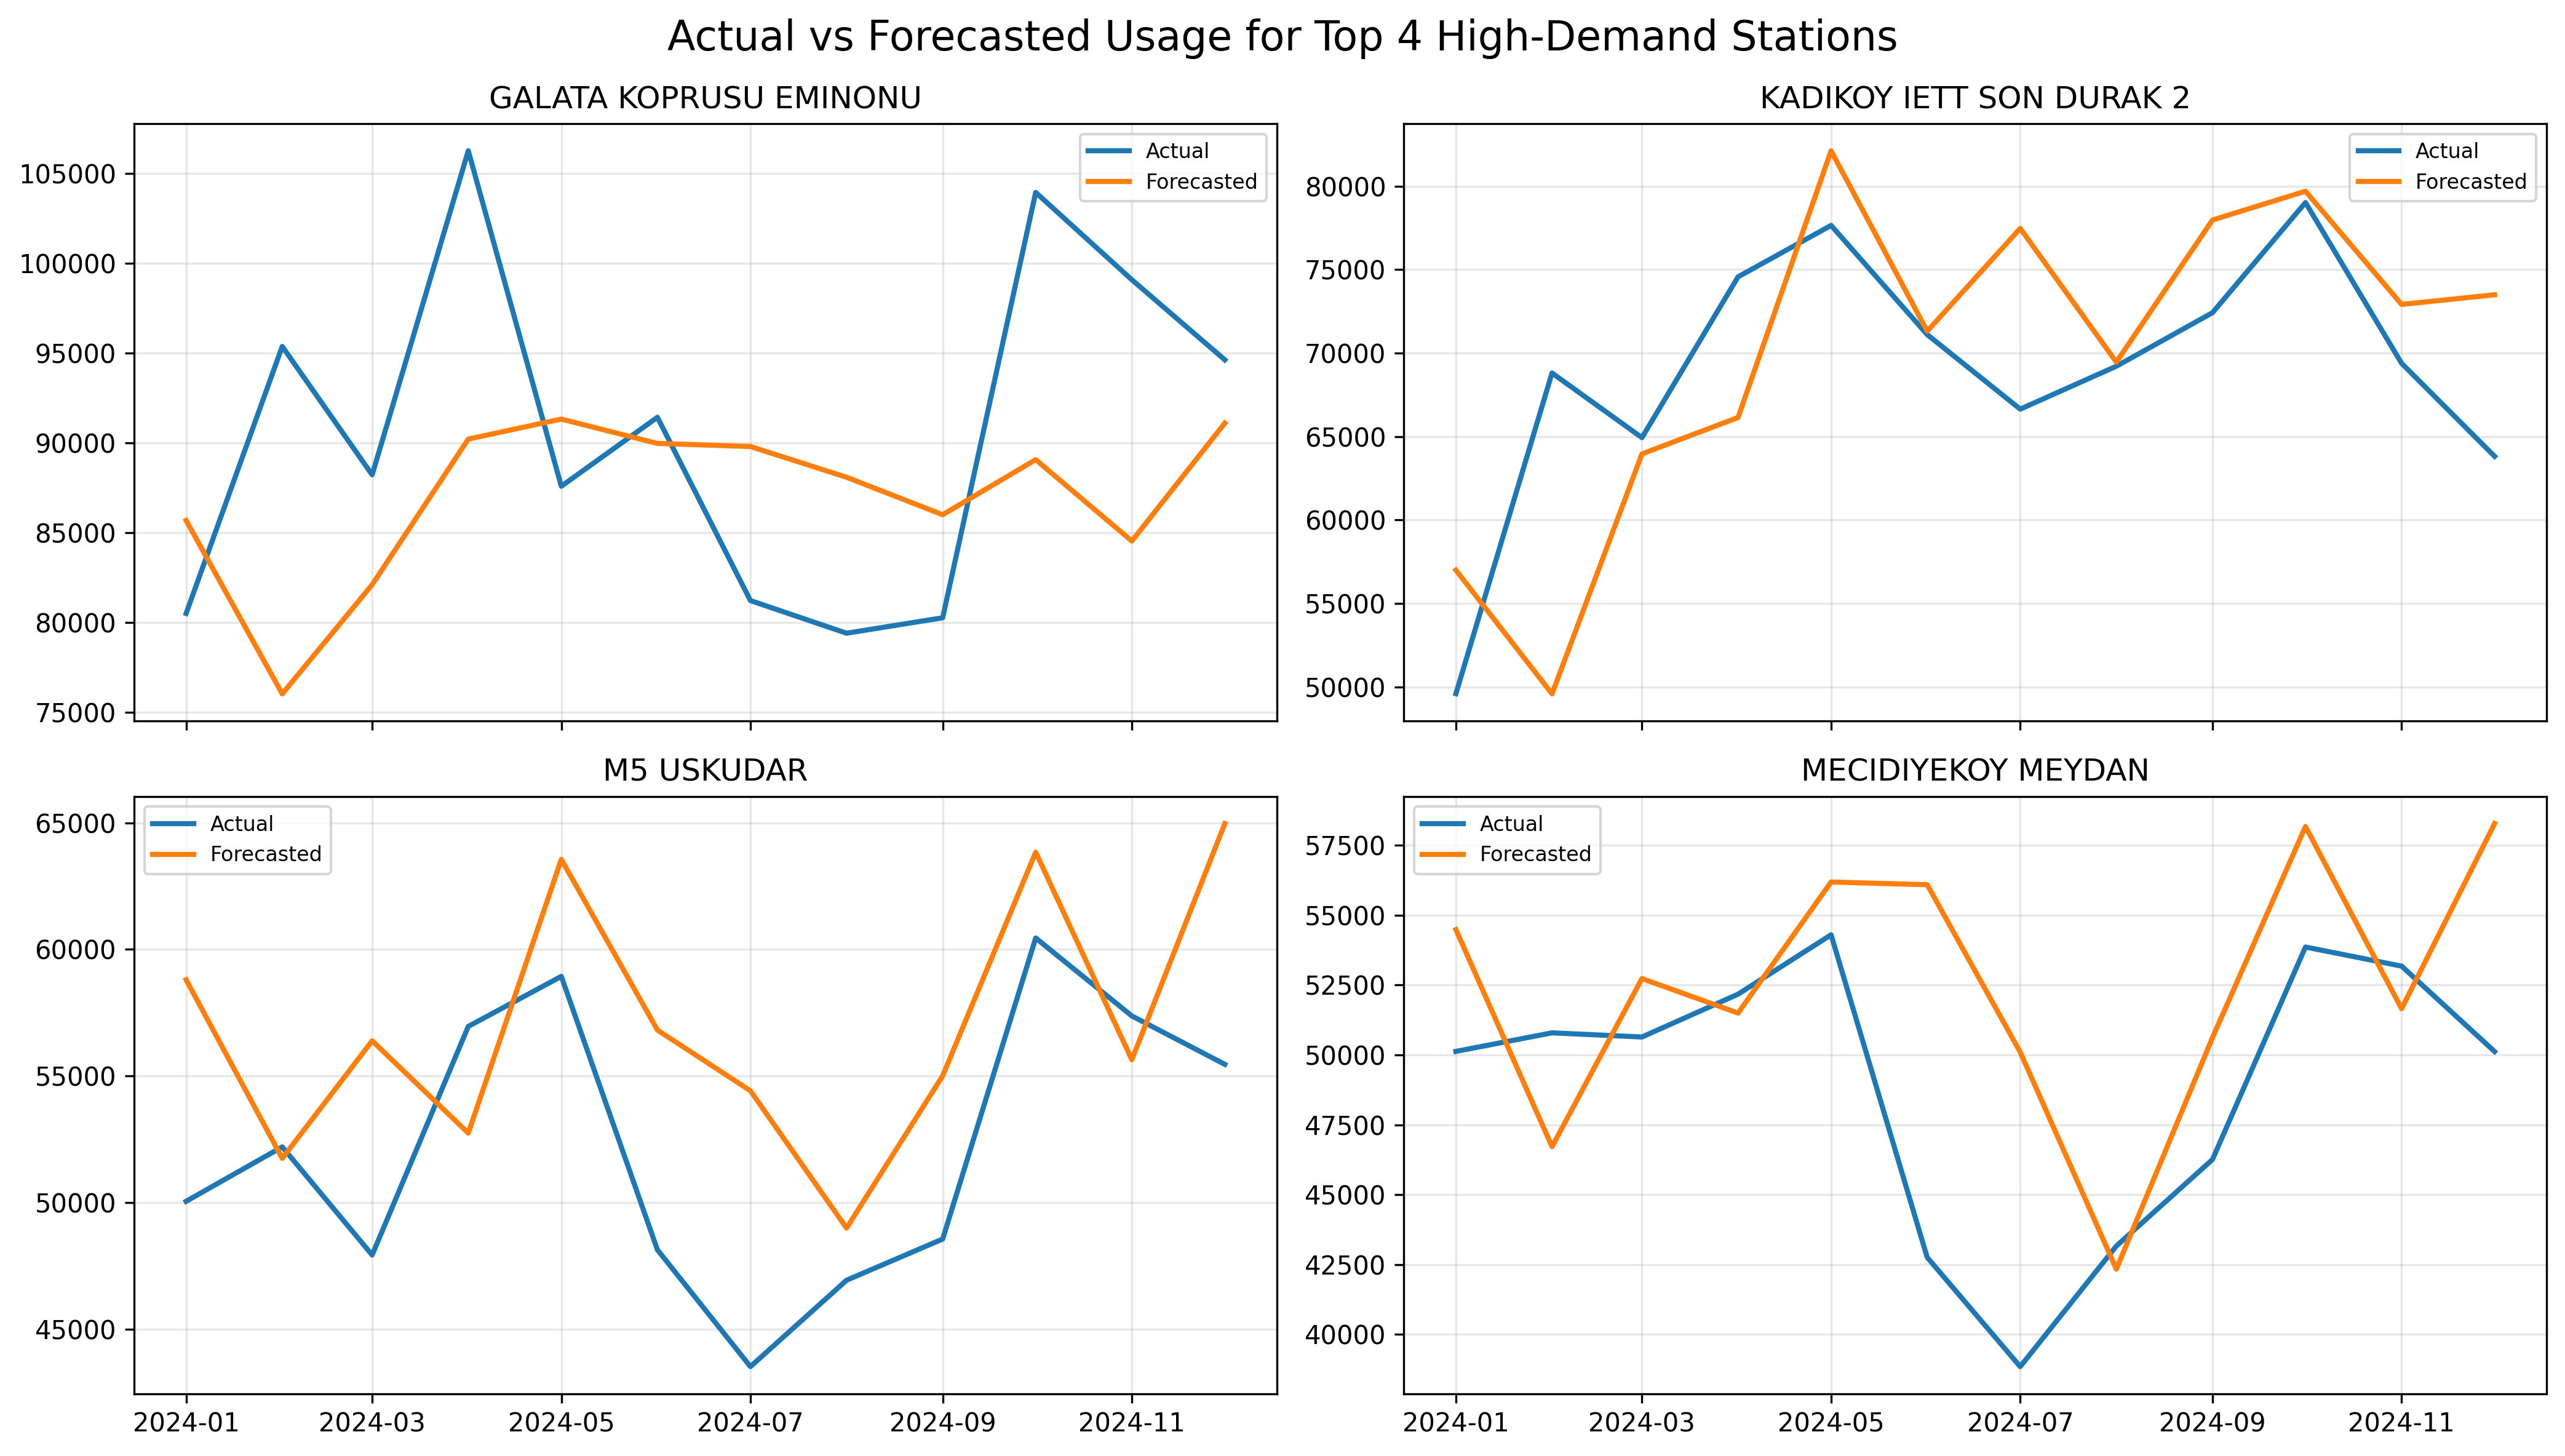

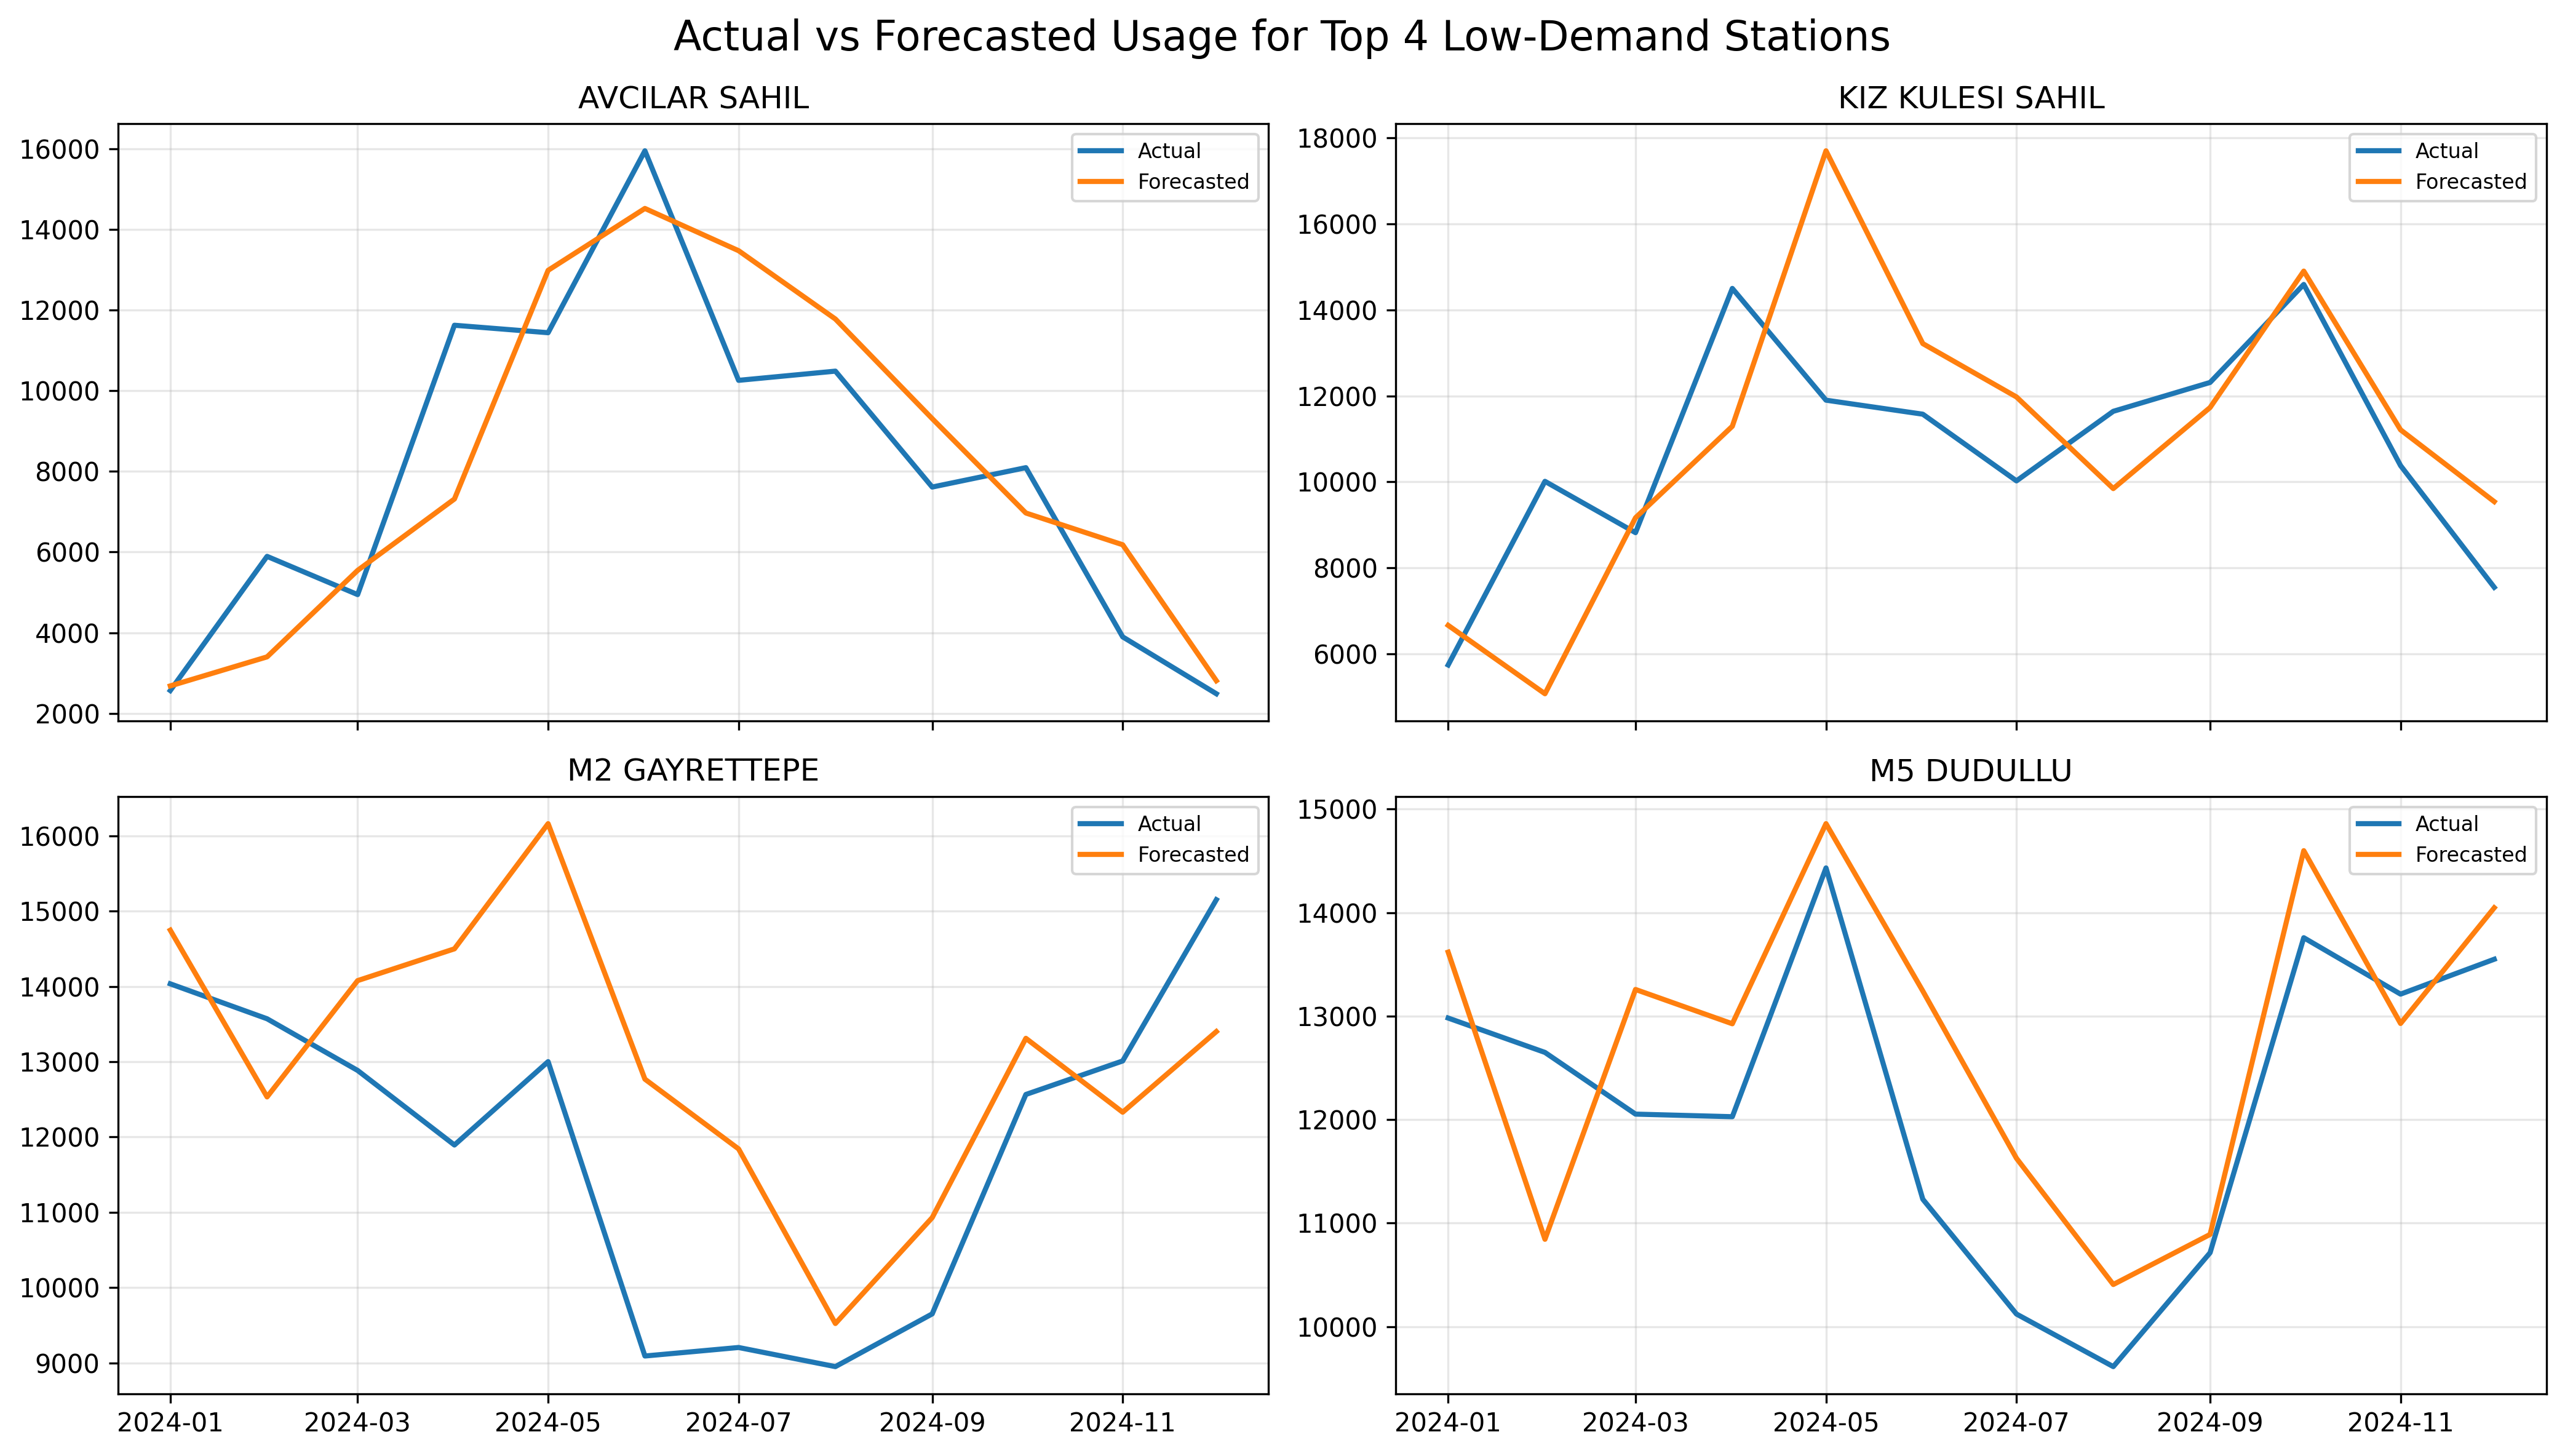

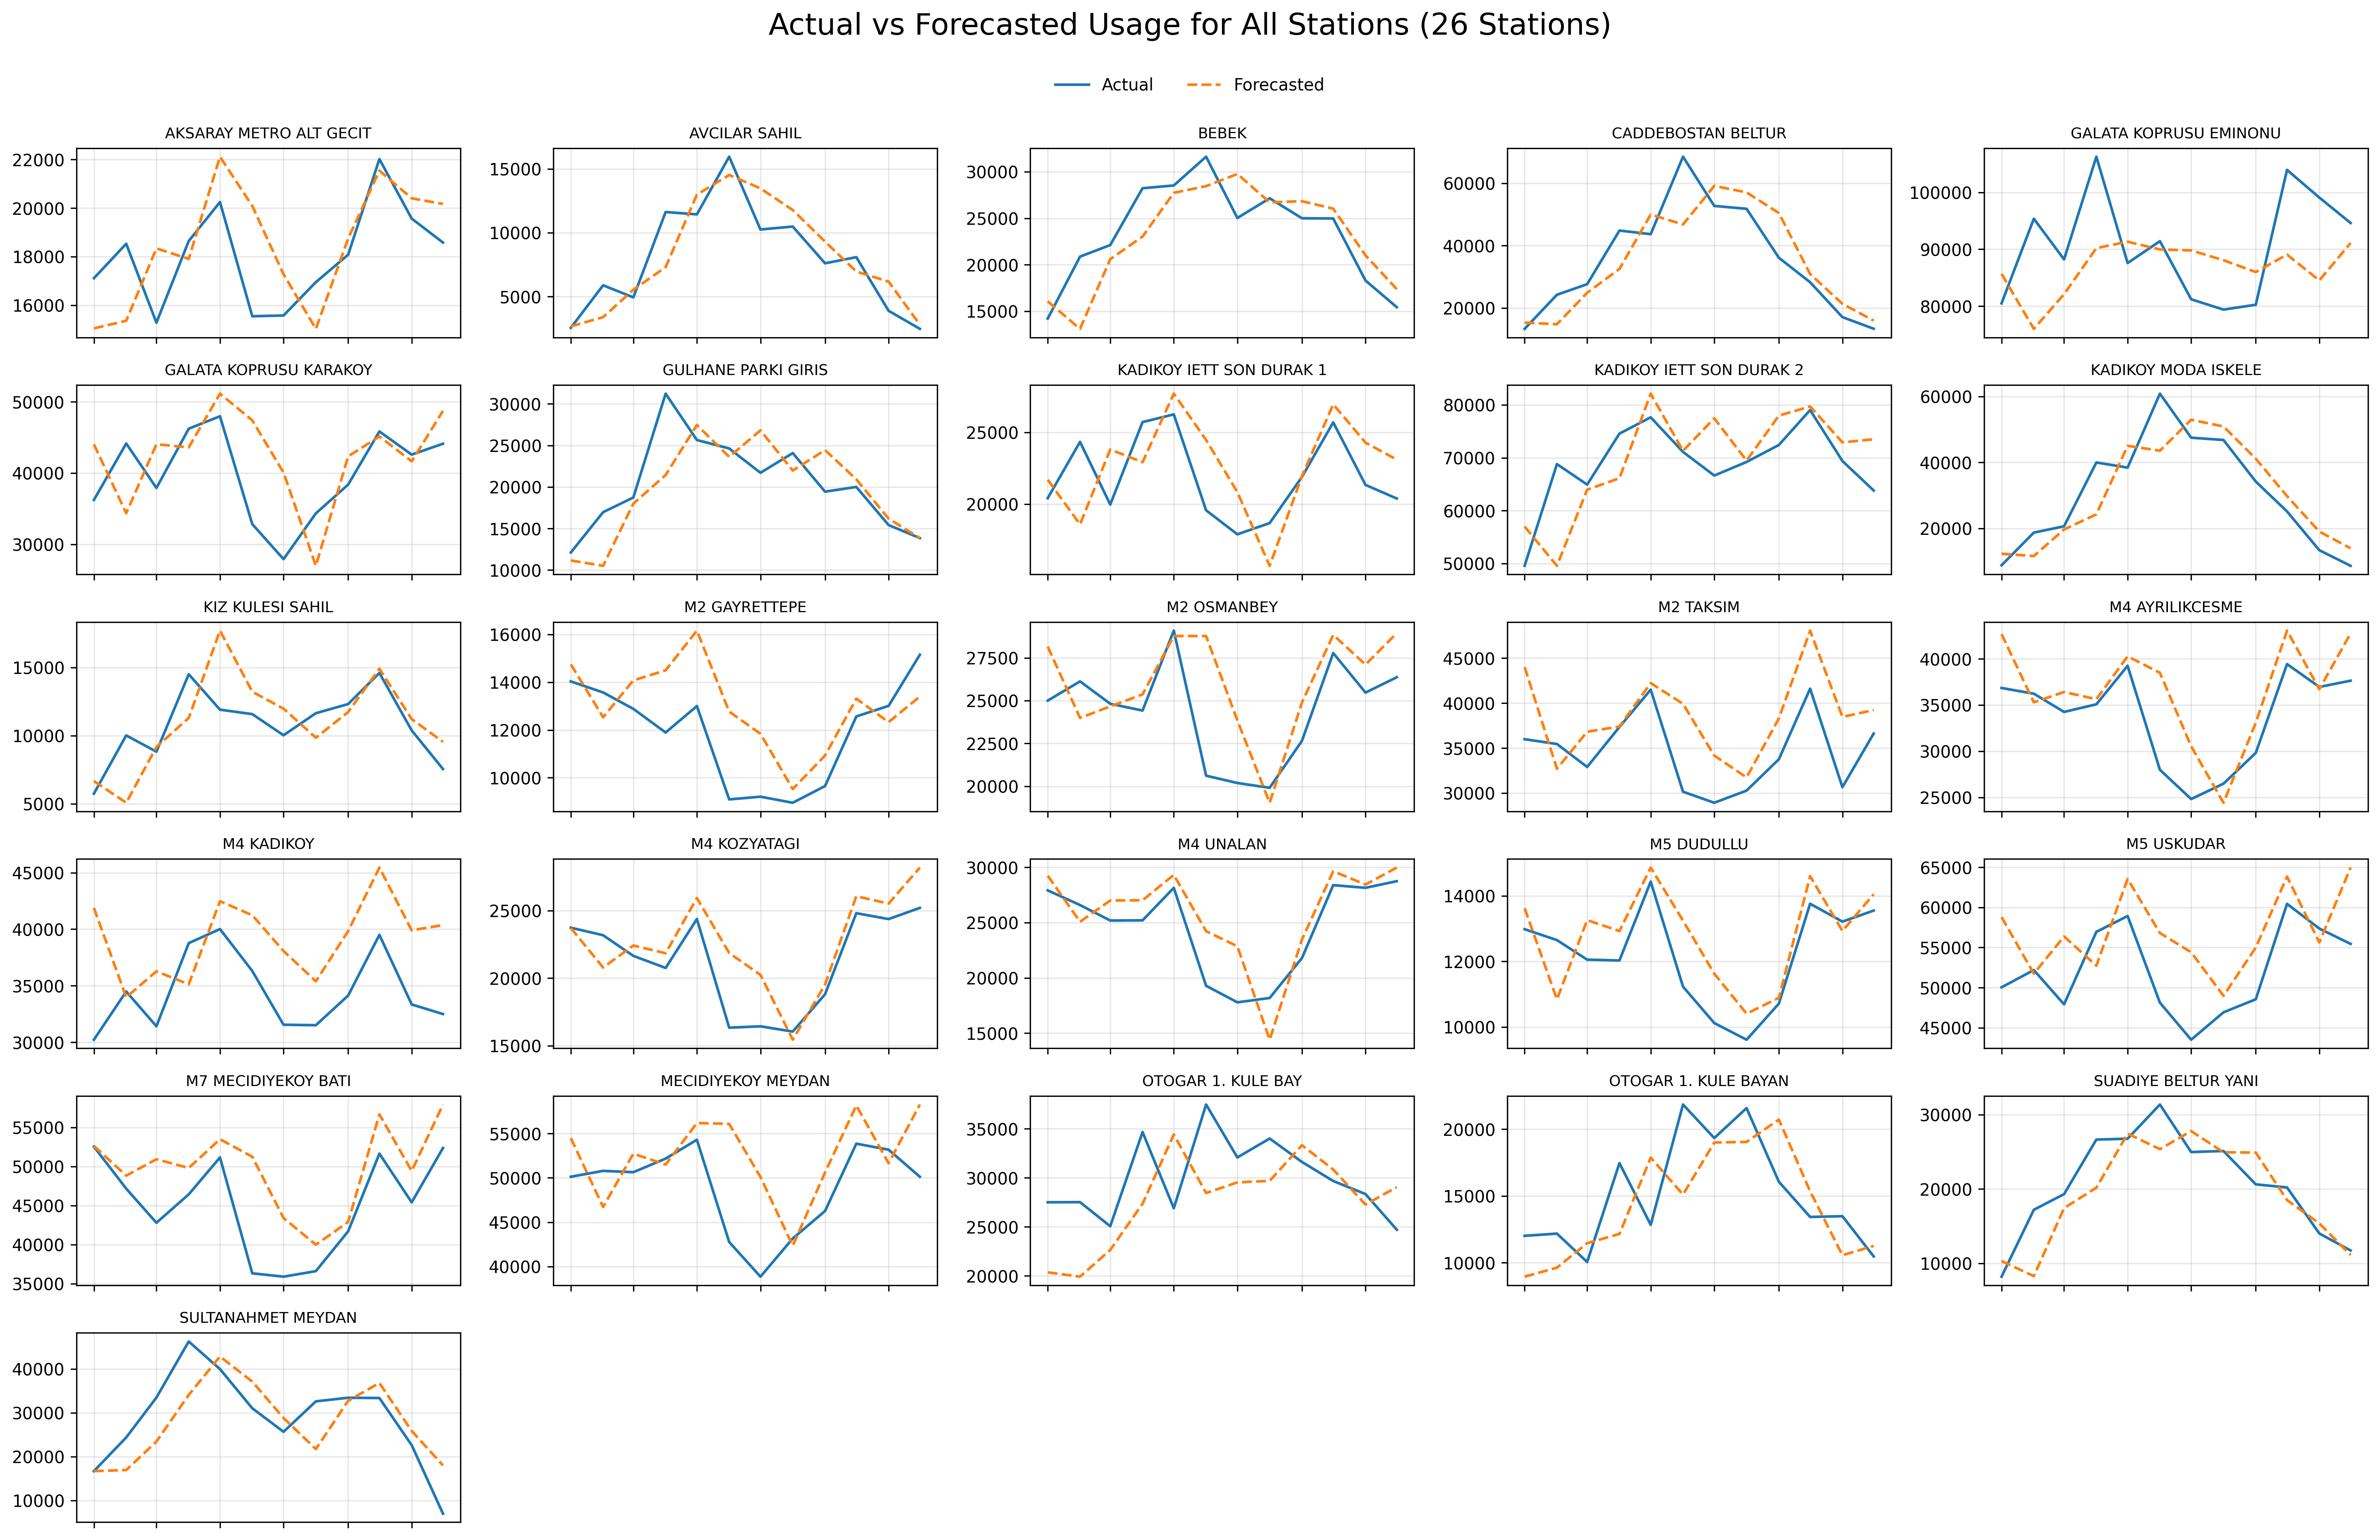

In [57]:
#--------------------------------------------------------------------
# ACTUAL vs FORECASTED PLOTTING (FOR TOP 4, LESS 4 AND ALL STATIONS)
#--------------------------------------------------------------------
pred_df = test_df.copy()
pred_df["y_true"] = y_test.values if hasattr(y_test, "values") else y_test
pred_df["y_pred"] = y_pred
pred_df["date"] = pd.to_datetime(pred_df["date"])
pred_df["abs_err"] = np.abs(pred_df["y_true"] - pred_df["y_pred"])
pred_df["err"] = pred_df["y_true"] - pred_df["y_pred"]

top_k = 4
most_busy = (pred_df.groupby("İstasyon")["y_true"].sum().sort_values(ascending=False).head(top_k).index.tolist())


fig, axes = plt.subplots(2, 2, figsize=(14, 8), sharex=True, dpi = 300)
axes = axes.flatten()
for ax, st in zip(axes, most_busy):
    s = pred_df[pred_df["İstasyon"] == st].sort_values("date")
    ax.plot(s["date"], s["y_true"], label="Actual", linewidth=2)
    ax.plot(s["date"], s["y_pred"], label="Forecasted", linewidth=2)
    ax.set_title(st)
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=8)
fig.suptitle("Actual vs Forecasted Usage for Top 4 High-Demand Stations", fontsize=16)
plt.tight_layout()
plt.show()
least_busy = (pred_df.groupby("İstasyon")["y_true"].sum().sort_values(ascending=True).head(top_k).index.tolist())
fig, axes = plt.subplots(2, 2, figsize=(14, 8), sharex=True, dpi = 300)
axes = axes.flatten()
for ax, st in zip(axes, least_busy):
    s = pred_df[pred_df["İstasyon"] == st].sort_values("date")
    ax.plot(s["date"], s["y_true"], label="Actual", linewidth=2)
    ax.plot(s["date"], s["y_pred"], label="Forecasted", linewidth=2)
    ax.set_title(st)
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=8)
fig.suptitle("Actual vs Forecasted Usage for Top 4 Low-Demand Stations", fontsize=16)
plt.tight_layout()
plt.show()
all_stations = sorted(pred_df["İstasyon"].unique())
if len(all_stations) != 26:
    raise ValueError(f"Beklenen 26 istasyon, bulunan: {len(all_stations)}")
fig, axes = plt.subplots(6, 5, figsize=(20, 14), sharex=True, dpi = 300)
axes = axes.flatten()
for i, (ax, st) in enumerate(zip(axes, all_stations)):
    s = pred_df[pred_df["İstasyon"] == st].sort_values("date")
    ax.plot(s["date"], s["y_true"], linewidth=1.6, label="Actual")
    ax.plot(s["date"], s["y_pred"], linewidth=1.6, linestyle="--", label="Forecasted")
    ax.set_title(st, fontsize=9)
    ax.grid(True, alpha=0.3)
for j in range(len(all_stations), len(axes)):
    axes[j].axis("off")
fig.suptitle("Actual vs Forecasted Usage for All Stations (26 Stations)",fontsize=18,y=0.93)
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles,labels,loc="upper center",ncol=2,frameon=False,bbox_to_anchor=(0.5, 0.90))
plt.tight_layout(rect=[0, 0, 1, 0.90])
for ax in axes:
    ax.tick_params(labelbottom=False)
plt.show()

/var/folders/3z/7sv1xp_96lgbrt8j1qdjwxdc0000gn/T/ipykernel_5376/3232832472.py:4: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  err_by_date = (pred_df.groupby("date").apply(lambda df: pd.Series({"MAE_over_time": mean_absolute_error(df["y_true"], df["y_pred"]),"RMSE_over_time": np.sqrt(mean_squared_error(df["y_true"], df["y_pred"]))})).reset_index().sort_values("date"))


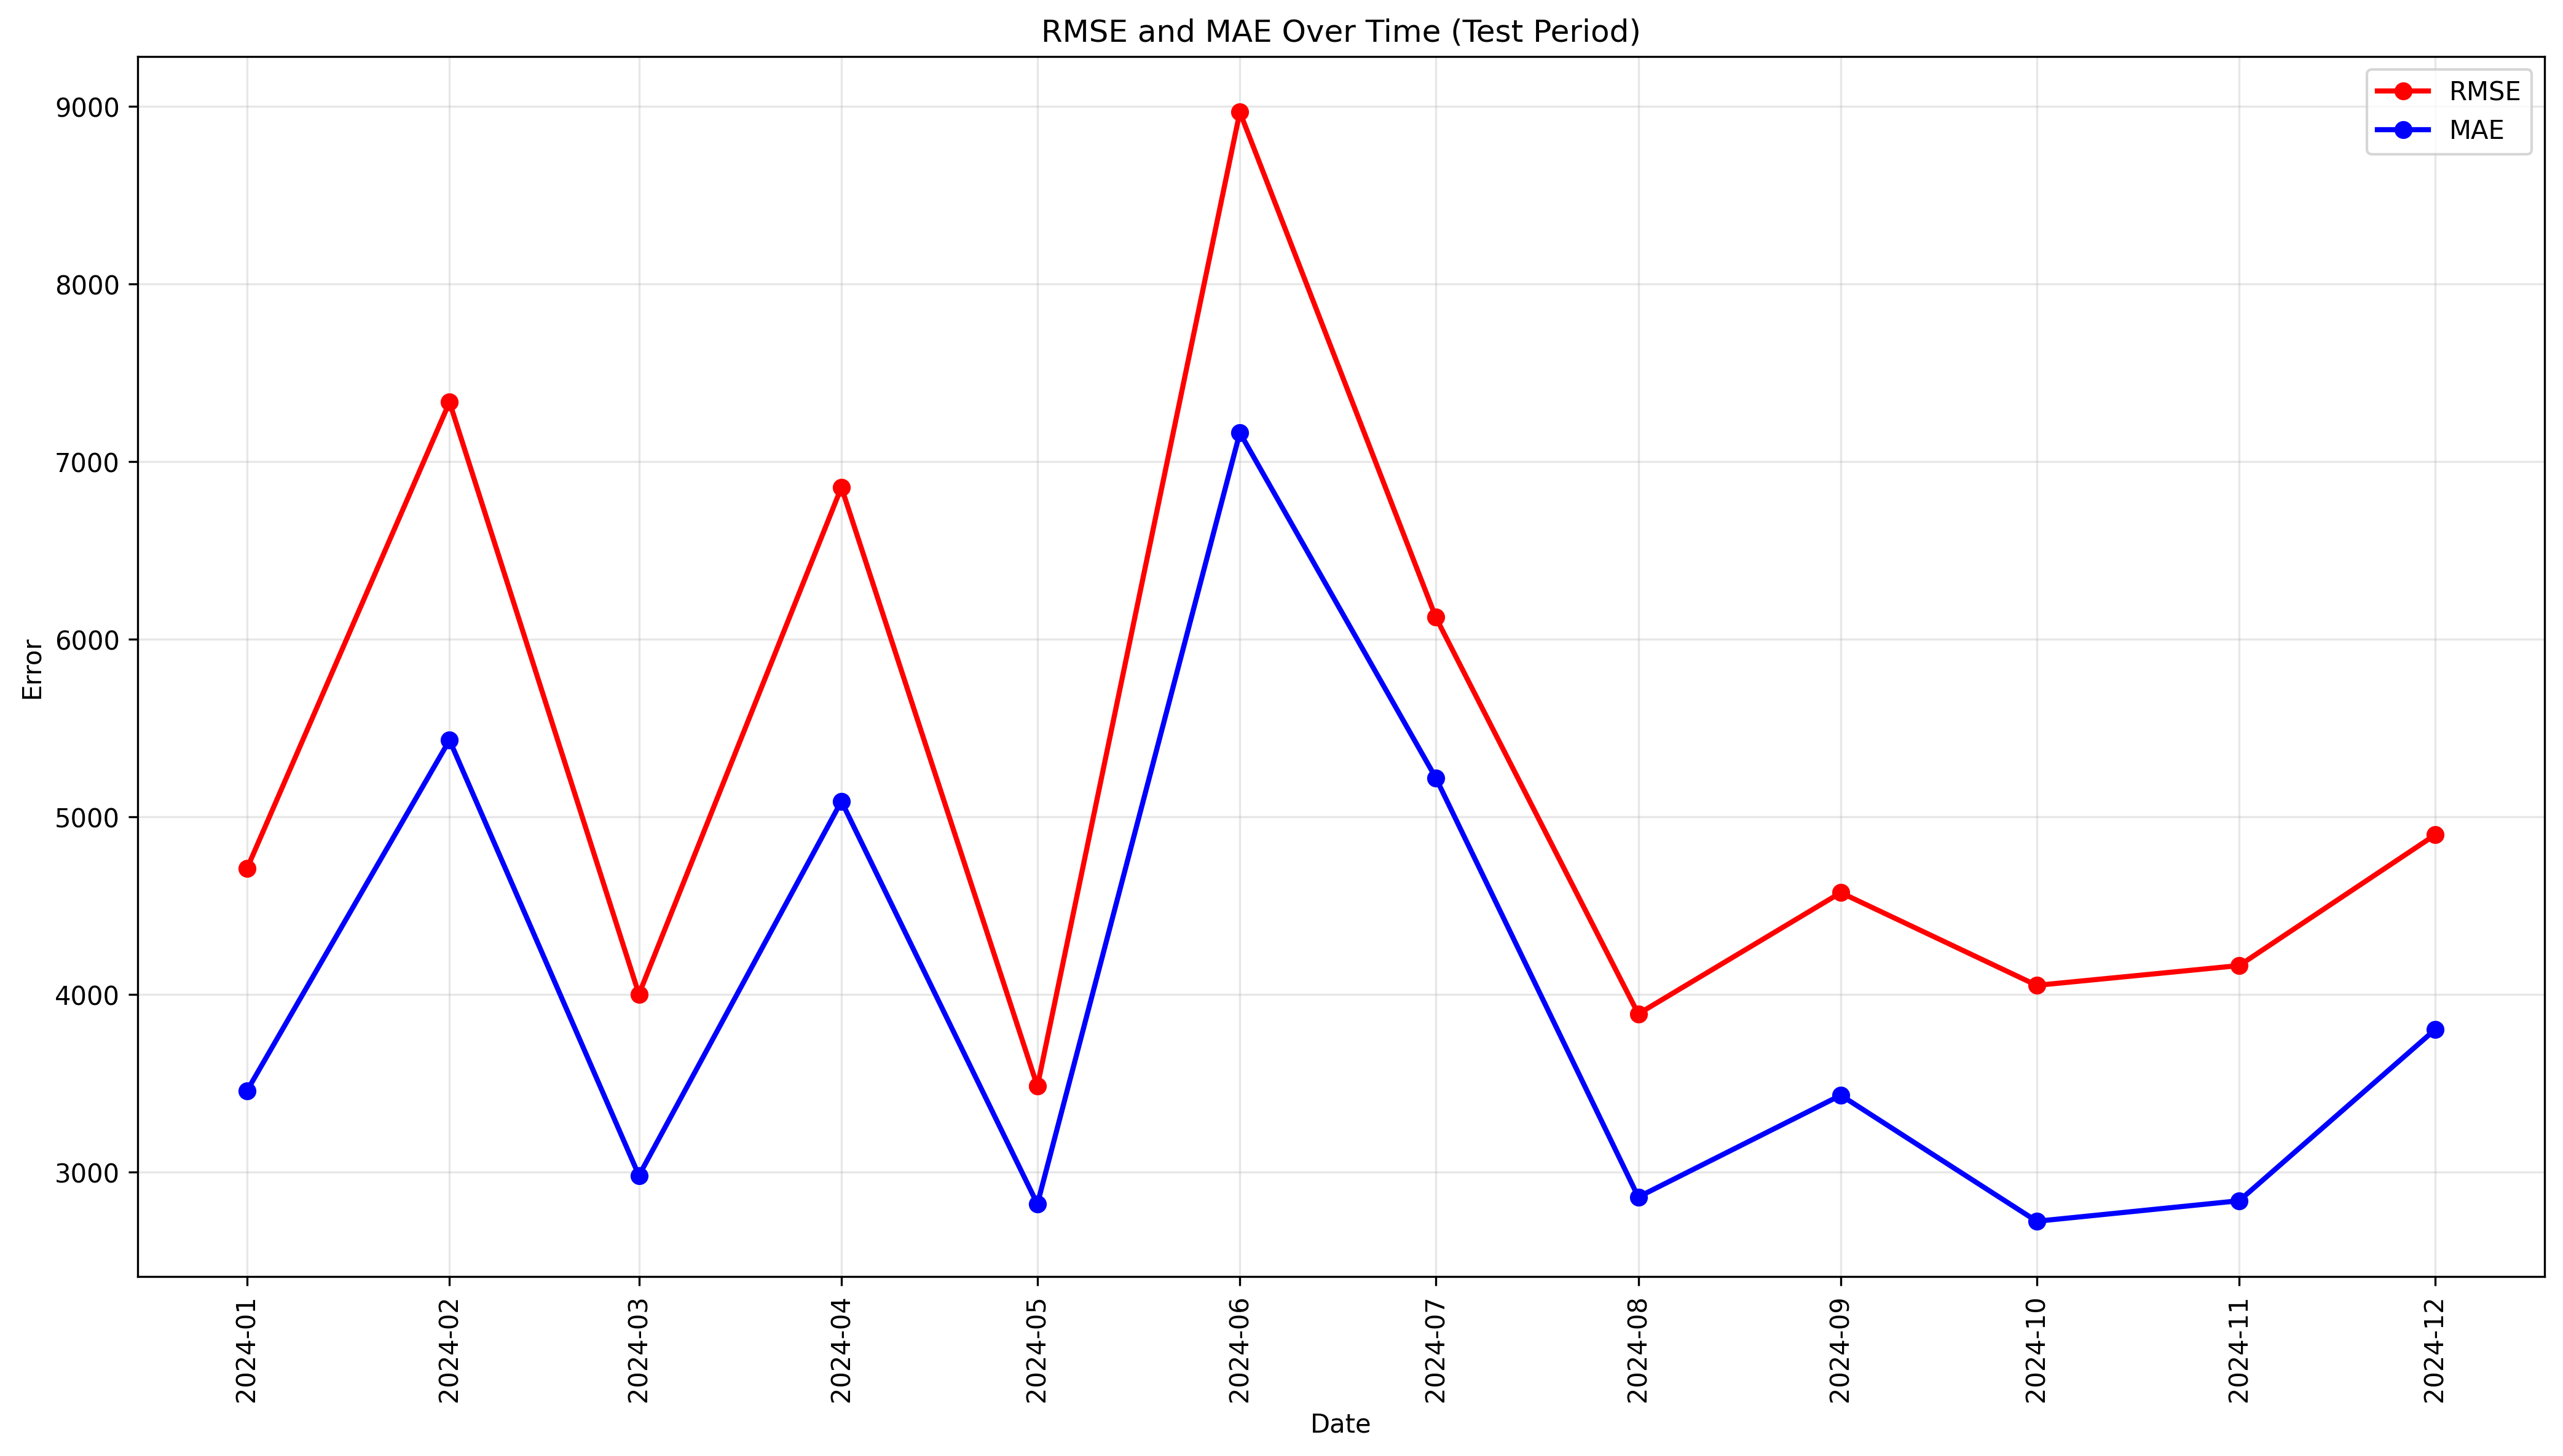

In [55]:
#----------------------------------
# RMSE AND MAE OVER TIME PLOTTING
#----------------------------------
err_by_date = (pred_df.groupby("date").apply(lambda df: pd.Series({"MAE_over_time": mean_absolute_error(df["y_true"], df["y_pred"]),"RMSE_over_time": np.sqrt(mean_squared_error(df["y_true"], df["y_pred"]))})).reset_index().sort_values("date"))

# Graph Settings
fig, ax = plt.subplots(figsize=(14, 8), dpi=300)
ax.plot(err_by_date["date"],err_by_date["RMSE_over_time"],marker="o",linewidth=2,color="red",label="RMSE")
ax.plot(err_by_date["date"],err_by_date["MAE_over_time"],marker="o",linewidth=2,color="blue",label="MAE")
ax.set_title("RMSE and MAE Over Time (Test Period)")
ax.set_xlabel("Date")
ax.set_ylabel("Error")
ax.grid(True, alpha=0.3)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.setp(ax.get_xticklabels(), rotation=90, ha="center")
ax.legend()
plt.tight_layout()
plt.show()

# Thank You for Reading :D